In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer # n-gram
from wordcloud import WordCloud
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from konlpy.tag import Okt,Hannanum, Kkma, Komoran
import time
import openpyxl
import re
import warnings
#from pykospacing import Spacing
#from mecab import MeCab

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

In [2]:
file_path = './Text_Data/bigkinds/삼성전자_사회_20170901-20240830.xlsx'

df_bigkinds = pd.read_excel(file_path, converters={'뉴스 식별자': str})  # '뉴스 식별자'는 해당 열의 실제 이름으로 대체

df_bigkinds

,뉴스 식별자,일자,언론사,기고자,제목,통합 분류1,통합 분류2,통합 분류3,사건/사고 분류1,사건/사고 분류2,사건/사고 분류3,인물,위치,기관,키워드,특성추출(가중치순 상위 50개),본문,URL,분석제외 여부
0,02100101.20170901163910001,20170901,매일경제,NaN,"이재용 항소심, 서울고법 형사 13부에 배당 이달중 첫 기일",사회>사건_사고,사회>교육_시험,NaN,범죄>정치>뇌물수수,NaN,NaN,"한만호,한명숙,이재용,이,박근혜,정형식,최순실",9억여원,"형사13부,재판부,항소심,서울고법","이재용,항소심,13부,서울고법,형사,배당,기일,박근혜,대통령,최순실씨,433억,뇌물...","항소심,부회장,서울고법,정형식,재판부,부장판사,추징금,삼성,관계자,삼성전자,이재용,...",박근혜 전 대통령과 최순실씨에게 433억원의 뇌물을 제공하거나 주기로 약속한 혐의(...,http://news.mk.co.kr/newsRead.php?year=2017&no...,NaN
1,02100101.20170901174354001,20170901,매일경제,김제이,최순실게이트 청문회 불출석 11인 중 8명 `백수`,사회>사건_사고,정치>청와대,정치>국회_정당,범죄>정치>뇌물수수,NaN,NaN,"윤전추,박상진,추명호,전,이,안봉근,안,우병우,김장자,이성한,이재만,최순실","경위도,국조특위","검찰,서울경찰청,국회,비서관,국정원,대법원,서울중앙지법,이화여대,국회증언감정법,청와...","불출석,최순실게이트,청문회,백수,문고리,안봉근,국정홍보비서관,이재만,총무비서관,국정...","비서관,청문회,재판부,최순실,공소사실,문고리,불출석,이화여대,삼성전자,김장자,피고인...",이른바 '문고리 3인방'으로 알려진 안봉근 전 국정홍보비서관과 이재만 전 총무비서관...,http://news.mk.co.kr/newsRead.php?year=2017&no...,NaN
2,02100101.20170901181209001,20170901,매일경제,정주원,`삼성 뇌물` 이재용 항소심 `신설` 형사13부 배당,사회>사건_사고,사회>여성,사회>교육_시험,범죄>정치>뇌물수수,NaN,NaN,"한명숙,박영수,이재용,이,김진동,박근혜,최지성,전현직,정형식,박상기,장충기,최순실","송파구,천왕동,문정동,평택지원장,구로구","형사13부(부장판사,형사13부,성남지원,형사합,대법원,청주지법,형사부,수원지법,서울...","삼성,뇌물,신설,이재용,항소심,형사,배당,부회장,이재용,삼성전자,항소심,재판부,서울...","항소심,부회장,삼성,부장판사,수원지법,서울고법,이재용,정형식,형사13부,서울구치소,...",이재용 삼성전자 부회장(49)의 항소심 재판부가 서울고법 형사13부(부장판사 정형식...,http://news.mk.co.kr/newsRead.php?year=2017&no...,NaN
3,02100101.20170901141935001,20170901,매일경제,정주원,두문불출 10개월만에 `문고리 실세` 이재만 안봉근 법정 나와 청문회불출석 인정,사회>사건_사고,정치>청와대,정치>국회_정당,NaN,NaN,NaN,"박상진,박근혜,안봉근,안,이성한,김장자,이재만,윤전추,김경숙,이,박,박평수,우병우",한일,"서울지방경찰청,형사12단독,검찰,국회,서울중앙지법,이화여대,청와대,국정홍보비서관,서...","두문불출,개월,문고리,실세,이재만,안봉근,법정,청문회불,출석,인정,박근혜,대통령,6...","비서관,청문회,이재만,문고리,불출석,청와대,변호인,서울중앙지법,피고인,박평수,박근혜...",박근혜 전 대통령(65 구속기소)의 '문고리 3인방'으로 불렸던 최측근 이재만 전 ...,http://news.mk.co.kr/newsRead.php?year=2017&no...,NaN
4,02100311.20170901153936001,20170901,서울경제,장주영 기자,"청문회 불출석 혐의, 건강상태-절차적 하자로 '무죄' 주장",정치>국회_정당,사회>사건_사고,정치>청와대,NaN,NaN,NaN,"김,김하영,박상진,추명호,박근혜,정호성,안봉근,이임순,정매주,김장자,박재홍,김경숙,...",한일,"형사3부,서울지방경찰청,형사12단독,검찰,국회,대법원,국정원,순천향대,특위,한국마사...","혐의,청문회,건강상태,절차적,하자,무죄,주장,국회,국정,농단,청문회,불출석,혐의,재...","청문회,청와대,비서관,국정원,요구서,건강상태,출석요구서,한국마사회,불출석,재판장,서...",지난해말 국회에서 열린 국정농단 청문회에 제멋대로 불출석한 혐의로 재판에 넘겨진 우...,http://www.sedaily.com/NewsView/1OKUY3ELL1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6055,02100601.20240826182228001,20240826,한국경제,오현우,수술 이송 재활 다 하는 로봇 의료대란 걱정 덜었다,사회>의료_건강,IT_과학>과학,NaN,NaN,NaN,NaN,NaN,"물류창고,스코틀랜드,일본","현대자동차,마케츠앤드마케츠,삼성전자,ZMP,리프","수술,이송,재활,로봇,의료대,걱정,고령화,필연적,의료,수요,의사,속도,환자,증가,속...","일본,봇핏,마케츠앤드마케츠,17건,스코틀랜드,해리엇와트대,하반신,무인이동로봇,위험도...",고령화는 필연적으로 의료 수요를 키운다. 의사가 늘어나는 속도보다 환자가 증가하는 ...,https://www.hankyung.com/article/2024082667731,NaN
6056,02100601.20240826161718002,20240826,한국경제,이해성,"삼성전자 기흥 피폭 작업자, 손에 기준치의 188배 피폭",사회>사회일반,IT_과학>과학,NaN,NaN,NaN,NaN,NaN,"기흥,서울,기흥캠퍼스","15mSv,한강성심병원,원자력안전위원회,원자력의학원,과학기술정보방송통신위원회,mS,...","삼성전자,기흥,피폭,작업자,기준치,피폭,5월,삼성전자,기흥,캠퍼스,반도체,시설,정비...","방사선,작업자,삼성전자,원안위,인터락,188배,기흥,반도체,기흥캠퍼스,위원회,유효선...",지난 5월 말 삼성전자 기흥캠퍼스에서 반도체 시설 정비 작업 중 피폭된 30대 작업...,https://www.hankyung.com/article/202408266335i,NaN
6057,02100101.20240827181505005,20240827,매일경제,NaN,[부음] 이금선씨 별세 외,사회>미디어,NaN,NaN,NaN,NaN,NaN,"함혜자 함혜순 함혜경 함혜란 함혜,윤종걸,김정숙,김익호,함현철,함혜은,유길상,태경,...","유경상,경남","원지산청,롯데칠성,수원대,(주)푸른기술,삼성전자,서울성모병원","이금선,별세,이금선,별세,유경상,부산남구장애인복지관장,유철상,롯데칠성,매니저,유영상...","성효중,모친상,발인,경남,시모상,함혜영,함혜자,유영상,롯데칠성,유철상,장애인,부산남...","▲이금선씨 별세, 유경상(부산남구장애인복지관장) 유철상(롯데칠성 매니저) 유영상(S...",http://www.mk.co.kr/article/11103036,예외
6058,02100311.20240827183150001,20240827,서울경제,류석 기자,[부고] 유영상 SK텔레콤 대표 모친상,IT_과학>모바일,사회>미디어,사회>장애인,NaN,NaN,NaN,유영상,"유경상,경남,산청군","롯데칠성,SK텔레콤,원지산청장,삼성전자","유영상,SK,텔레콤,대표,모친상,이금선,별세,유경상,부산남구장애인복지관장,철상,롯데...","모친상,산청군,경남,유영상,원지산청장례식장,철상,장애인,롯데칠성,부산남구,부산남구장...","▲이금선씨 별세, 유경상(부산남구장애인복지관장) 철상(롯데칠성 매니저) 영상(SK텔...",http://www.sedaily.com/NewsView/2DD6I6CEXO,예외


크롤링 과정에서 중복건이 발생할 수 있어 확인했으나 이상 없음

In [4]:
df_bigkinds = df_bigkinds.drop_duplicates()

df_bigkinds

,뉴스 식별자,일자,언론사,기고자,제목,통합 분류1,통합 분류2,통합 분류3,사건/사고 분류1,사건/사고 분류2,사건/사고 분류3,인물,위치,기관,키워드,특성추출(가중치순 상위 50개),본문,URL,분석제외 여부
0,02100101.20170901163910001,20170901,매일경제,NaN,"이재용 항소심, 서울고법 형사 13부에 배당 이달중 첫 기일",사회>사건_사고,사회>교육_시험,NaN,범죄>정치>뇌물수수,NaN,NaN,"한만호,한명숙,이재용,이,박근혜,정형식,최순실",9억여원,"형사13부,재판부,항소심,서울고법","이재용,항소심,13부,서울고법,형사,배당,기일,박근혜,대통령,최순실씨,433억,뇌물...","항소심,부회장,서울고법,정형식,재판부,부장판사,추징금,삼성,관계자,삼성전자,이재용,...",박근혜 전 대통령과 최순실씨에게 433억원의 뇌물을 제공하거나 주기로 약속한 혐의(...,http://news.mk.co.kr/newsRead.php?year=2017&no...,NaN
1,02100101.20170901174354001,20170901,매일경제,김제이,최순실게이트 청문회 불출석 11인 중 8명 `백수`,사회>사건_사고,정치>청와대,정치>국회_정당,범죄>정치>뇌물수수,NaN,NaN,"윤전추,박상진,추명호,전,이,안봉근,안,우병우,김장자,이성한,이재만,최순실","경위도,국조특위","검찰,서울경찰청,국회,비서관,국정원,대법원,서울중앙지법,이화여대,국회증언감정법,청와...","불출석,최순실게이트,청문회,백수,문고리,안봉근,국정홍보비서관,이재만,총무비서관,국정...","비서관,청문회,재판부,최순실,공소사실,문고리,불출석,이화여대,삼성전자,김장자,피고인...",이른바 '문고리 3인방'으로 알려진 안봉근 전 국정홍보비서관과 이재만 전 총무비서관...,http://news.mk.co.kr/newsRead.php?year=2017&no...,NaN
2,02100101.20170901181209001,20170901,매일경제,정주원,`삼성 뇌물` 이재용 항소심 `신설` 형사13부 배당,사회>사건_사고,사회>여성,사회>교육_시험,범죄>정치>뇌물수수,NaN,NaN,"한명숙,박영수,이재용,이,김진동,박근혜,최지성,전현직,정형식,박상기,장충기,최순실","송파구,천왕동,문정동,평택지원장,구로구","형사13부(부장판사,형사13부,성남지원,형사합,대법원,청주지법,형사부,수원지법,서울...","삼성,뇌물,신설,이재용,항소심,형사,배당,부회장,이재용,삼성전자,항소심,재판부,서울...","항소심,부회장,삼성,부장판사,수원지법,서울고법,이재용,정형식,형사13부,서울구치소,...",이재용 삼성전자 부회장(49)의 항소심 재판부가 서울고법 형사13부(부장판사 정형식...,http://news.mk.co.kr/newsRead.php?year=2017&no...,NaN
3,02100101.20170901141935001,20170901,매일경제,정주원,두문불출 10개월만에 `문고리 실세` 이재만 안봉근 법정 나와 청문회불출석 인정,사회>사건_사고,정치>청와대,정치>국회_정당,NaN,NaN,NaN,"박상진,박근혜,안봉근,안,이성한,김장자,이재만,윤전추,김경숙,이,박,박평수,우병우",한일,"서울지방경찰청,형사12단독,검찰,국회,서울중앙지법,이화여대,청와대,국정홍보비서관,서...","두문불출,개월,문고리,실세,이재만,안봉근,법정,청문회불,출석,인정,박근혜,대통령,6...","비서관,청문회,이재만,문고리,불출석,청와대,변호인,서울중앙지법,피고인,박평수,박근혜...",박근혜 전 대통령(65 구속기소)의 '문고리 3인방'으로 불렸던 최측근 이재만 전 ...,http://news.mk.co.kr/newsRead.php?year=2017&no...,NaN
4,02100311.20170901153936001,20170901,서울경제,장주영 기자,"청문회 불출석 혐의, 건강상태-절차적 하자로 '무죄' 주장",정치>국회_정당,사회>사건_사고,정치>청와대,NaN,NaN,NaN,"김,김하영,박상진,추명호,박근혜,정호성,안봉근,이임순,정매주,김장자,박재홍,김경숙,...",한일,"형사3부,서울지방경찰청,형사12단독,검찰,국회,대법원,국정원,순천향대,특위,한국마사...","혐의,청문회,건강상태,절차적,하자,무죄,주장,국회,국정,농단,청문회,불출석,혐의,재...","청문회,청와대,비서관,국정원,요구서,건강상태,출석요구서,한국마사회,불출석,재판장,서...",지난해말 국회에서 열린 국정농단 청문회에 제멋대로 불출석한 혐의로 재판에 넘겨진 우...,http://www.sedaily.com/NewsView/1OKUY3ELL1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6055,02100601.20240826182228001,20240826,한국경제,오현우,수술 이송 재활 다 하는 로봇 의료대란 걱정 덜었다,사회>의료_건강,IT_과학>과학,NaN,NaN,NaN,NaN,NaN,"물류창고,스코틀랜드,일본","현대자동차,마케츠앤드마케츠,삼성전자,ZMP,리프","수술,이송,재활,로봇,의료대,걱정,고령화,필연적,의료,수요,의사,속도,환자,증가,속...","일본,봇핏,마케츠앤드마케츠,17건,스코틀랜드,해리엇와트대,하반신,무인이동로봇,위험도...",고령화는 필연적으로 의료 수요를 키운다. 의사가 늘어나는 속도보다 환자가 증가하는 ...,https://www.hankyung.com/article/2024082667731,NaN
6056,02100601.20240826161718002,20240826,한국경제,이해성,"삼성전자 기흥 피폭 작업자, 손에 기준치의 188배 피폭",사회>사회일반,IT_과학>과학,NaN,NaN,NaN,NaN,NaN,"기흥,서울,기흥캠퍼스","15mSv,한강성심병원,원자력안전위원회,원자력의학원,과학기술정보방송통신위원회,mS,...","삼성전자,기흥,피폭,작업자,기준치,피폭,5월,삼성전자,기흥,캠퍼스,반도체,시설,정비...","방사선,작업자,삼성전자,원안위,인터락,188배,기흥,반도체,기흥캠퍼스,위원회,유효선...",지난 5월 말 삼성전자 기흥캠퍼스에서 반도체 시설 정비 작업 중 피폭된 30대 작업...,https://www.hankyung.com/article/202408266335i,NaN
6057,02100101.20240827181505005,20240827,매일경제,NaN,[부음] 이금선씨 별세 외,사회>미디어,NaN,NaN,NaN,NaN,NaN,"함혜자 함혜순 함혜경 함혜란 함혜,윤종걸,김정숙,김익호,함현철,함혜은,유길상,태경,...","유경상,경남","원지산청,롯데칠성,수원대,(주)푸른기술,삼성전자,서울성모병원","이금선,별세,이금선,별세,유경상,부산남구장애인복지관장,유철상,롯데칠성,매니저,유영상...","성효중,모친상,발인,경남,시모상,함혜영,함혜자,유영상,롯데칠성,유철상,장애인,부산남...","▲이금선씨 별세, 유경상(부산남구장애인복지관장) 유철상(롯데칠성 매니저) 유영상(S...",http://www.mk.co.kr/article/11103036,예외
6058,02100311.20240827183150001,20240827,서울경제,류석 기자,[부고] 유영상 SK텔레콤 대표 모친상,IT_과학>모바일,사회>미디어,사회>장애인,NaN,NaN,NaN,유영상,"유경상,경남,산청군","롯데칠성,SK텔레콤,원지산청장,삼성전자","유영상,SK,텔레콤,대표,모친상,이금선,별세,유경상,부산남구장애인복지관장,철상,롯데...","모친상,산청군,경남,유영상,원지산청장례식장,철상,장애인,롯데칠성,부산남구,부산남구장...","▲이금선씨 별세, 유경상(부산남구장애인복지관장) 철상(롯데칠성 매니저) 영상(SK텔...",http://www.sedaily.com/NewsView/2DD6I6CEXO,예외


전처리(제목과 세부내용이 겹쳐서 세부내용 일부 전처리, 제목 제거 후 제목+세부내용으로 병합하여 처리)

In [6]:
df_bigkinds.dtypes

뉴스 식별자               object
일자                    int64
언론사                  object
기고자                  object
제목                   object
통합 분류1               object
통합 분류2               object
통합 분류3               object
사건/사고 분류1            object
사건/사고 분류2            object
사건/사고 분류3            object
인물                   object
위치                   object
기관                   object
키워드                  object
특성추출(가중치순 상위 50개)    object
본문                   object
URL                  object
분석제외 여부              object
dtype: object

In [8]:
# '일자' 열을 명시적으로 'YYYYMMDD' 형식으로 변환
df_bigkinds.loc[:, '일자'] = pd.to_datetime(df_bigkinds['일자'], format='%Y%m%d')

C:\Users\dybae\AppData\Local\Temp\ipykernel_31196\2768489036.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<DatetimeArray>
['2017-09-01 00:00:00', '2017-09-01 00:00:00', '2017-09-01 00:00:00',
 '2017-09-01 00:00:00', '2017-09-01 00:00:00', '2017-09-01 00:00:00',
 '2017-09-04 00:00:00', '2017-09-04 00:00:00', '2017-09-04 00:00:00',
 '2017-09-05 00:00:00',
 ...
 '2024-08-20 00:00:00', '2024-08-21 00:00:00', '2024-08-22 00:00:00',
 '2024-08-23 00:00:00', '2024-08-25 00:00:00', '2024-08-26 00:00:00',
 '2024-08-26 00:00:00', '2024-08-27 00:00:00', '2024-08-27 00:00:00',
 '2024-08-29 00:00:00']
Length: 6060, dtype: datetime64[ns]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_bigkinds.loc[:, '일자'] = pd.to_datetime(df_bigkinds['일자'], format='%Y%m%d')


In [9]:
len(df_bigkinds)

6060

In [15]:
df_bigkinds['제목_키워드'] = df_bigkinds['제목'] + ' ' + df_bigkinds['키워드']

In [17]:
df_bigkinds

,뉴스 식별자,일자,언론사,기고자,제목,통합 분류1,통합 분류2,통합 분류3,사건/사고 분류1,사건/사고 분류2,사건/사고 분류3,인물,위치,기관,키워드,특성추출(가중치순 상위 50개),본문,URL,분석제외 여부,제목_키워드
0,02100101.20170901163910001,2017-09-01,매일경제,NaN,"이재용 항소심, 서울고법 형사 13부에 배당 이달중 첫 기일",사회>사건_사고,사회>교육_시험,NaN,범죄>정치>뇌물수수,NaN,NaN,"한만호,한명숙,이재용,이,박근혜,정형식,최순실",9억여원,"형사13부,재판부,항소심,서울고법","이재용,항소심,13부,서울고법,형사,배당,기일,박근혜,대통령,최순실씨,433억,뇌물...","항소심,부회장,서울고법,정형식,재판부,부장판사,추징금,삼성,관계자,삼성전자,이재용,...",박근혜 전 대통령과 최순실씨에게 433억원의 뇌물을 제공하거나 주기로 약속한 혐의(...,http://news.mk.co.kr/newsRead.php?year=2017&no...,NaN,"이재용 항소심, 서울고법 형사 13부에 배당 이달중 첫 기일 이재용,항소심,13부,..."
1,02100101.20170901174354001,2017-09-01,매일경제,김제이,최순실게이트 청문회 불출석 11인 중 8명 `백수`,사회>사건_사고,정치>청와대,정치>국회_정당,범죄>정치>뇌물수수,NaN,NaN,"윤전추,박상진,추명호,전,이,안봉근,안,우병우,김장자,이성한,이재만,최순실","경위도,국조특위","검찰,서울경찰청,국회,비서관,국정원,대법원,서울중앙지법,이화여대,국회증언감정법,청와...","불출석,최순실게이트,청문회,백수,문고리,안봉근,국정홍보비서관,이재만,총무비서관,국정...","비서관,청문회,재판부,최순실,공소사실,문고리,불출석,이화여대,삼성전자,김장자,피고인...",이른바 '문고리 3인방'으로 알려진 안봉근 전 국정홍보비서관과 이재만 전 총무비서관...,http://news.mk.co.kr/newsRead.php?year=2017&no...,NaN,"최순실게이트 청문회 불출석 11인 중 8명 `백수` 불출석,최순실게이트,청문회,백수..."
2,02100101.20170901181209001,2017-09-01,매일경제,정주원,`삼성 뇌물` 이재용 항소심 `신설` 형사13부 배당,사회>사건_사고,사회>여성,사회>교육_시험,범죄>정치>뇌물수수,NaN,NaN,"한명숙,박영수,이재용,이,김진동,박근혜,최지성,전현직,정형식,박상기,장충기,최순실","송파구,천왕동,문정동,평택지원장,구로구","형사13부(부장판사,형사13부,성남지원,형사합,대법원,청주지법,형사부,수원지법,서울...","삼성,뇌물,신설,이재용,항소심,형사,배당,부회장,이재용,삼성전자,항소심,재판부,서울...","항소심,부회장,삼성,부장판사,수원지법,서울고법,이재용,정형식,형사13부,서울구치소,...",이재용 삼성전자 부회장(49)의 항소심 재판부가 서울고법 형사13부(부장판사 정형식...,http://news.mk.co.kr/newsRead.php?year=2017&no...,NaN,"`삼성 뇌물` 이재용 항소심 `신설` 형사13부 배당 삼성,뇌물,신설,이재용,항소심..."
3,02100101.20170901141935001,2017-09-01,매일경제,정주원,두문불출 10개월만에 `문고리 실세` 이재만 안봉근 법정 나와 청문회불출석 인정,사회>사건_사고,정치>청와대,정치>국회_정당,NaN,NaN,NaN,"박상진,박근혜,안봉근,안,이성한,김장자,이재만,윤전추,김경숙,이,박,박평수,우병우",한일,"서울지방경찰청,형사12단독,검찰,국회,서울중앙지법,이화여대,청와대,국정홍보비서관,서...","두문불출,개월,문고리,실세,이재만,안봉근,법정,청문회불,출석,인정,박근혜,대통령,6...","비서관,청문회,이재만,문고리,불출석,청와대,변호인,서울중앙지법,피고인,박평수,박근혜...",박근혜 전 대통령(65 구속기소)의 '문고리 3인방'으로 불렸던 최측근 이재만 전 ...,http://news.mk.co.kr/newsRead.php?year=2017&no...,NaN,두문불출 10개월만에 `문고리 실세` 이재만 안봉근 법정 나와 청문회불출석 인정 두...
4,02100311.20170901153936001,2017-09-01,서울경제,장주영 기자,"청문회 불출석 혐의, 건강상태-절차적 하자로 '무죄' 주장",정치>국회_정당,사회>사건_사고,정치>청와대,NaN,NaN,NaN,"김,김하영,박상진,추명호,박근혜,정호성,안봉근,이임순,정매주,김장자,박재홍,김경숙,...",한일,"형사3부,서울지방경찰청,형사12단독,검찰,국회,대법원,국정원,순천향대,특위,한국마사...","혐의,청문회,건강상태,절차적,하자,무죄,주장,국회,국정,농단,청문회,불출석,혐의,재...","청문회,청와대,비서관,국정원,요구서,건강상태,출석요구서,한국마사회,불출석,재판장,서...",지난해말 국회에서 열린 국정농단 청문회에 제멋대로 불출석한 혐의로 재판에 넘겨진 우...,http://www.sedaily.com/NewsView/1OKUY3ELL1,NaN,"청문회 불출석 혐의, 건강상태-절차적 하자로 '무죄' 주장 혐의,청문회,건강상태,절..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6055,02100601.20240826182228001,2024-08-26,한국경제,오현우,수술 이송 재활 다 하는 로봇 의료대란 걱정 덜었다,사회>의료_건강,IT_과학>과학,NaN,NaN,NaN,NaN,NaN,"물류창고,스코틀랜드,일본","현대자동차,마케츠앤드마케츠,삼성전자,ZMP,리프","수술,이송,재활,로봇,의료대,걱정,고령화,필연적,의료,수요,의사,속도,환자,증가,속...","일본,봇핏,마케츠앤드마케츠,17건,스코틀랜드,해리엇와트대,하반신,무인이동로봇,위험도...",고령화는 필연적으로 의료 수요를 키운다. 의사가 늘어나는 속도보다 환자가 증가하는 ...,https://www.hankyung.com/article/2024082667731,NaN,"수술 이송 재활 다 하는 로봇 의료대란 걱정 덜었다 수술,이송,재활,로봇,의료대,걱..."
6056,02100601.20240826161718002,2024-08-26,한국경제,이해성,"삼성전자 기흥 피폭 작업자, 손에 기준치의 188배 피폭",사회>사회일반,IT_과학>과학,NaN,NaN,NaN,NaN,NaN,"기흥,서울,기흥캠퍼스","15mSv,한강성심병원,원자력안전위원회,원자력의학원,과학기술정보방송통신위원회,mS,...","삼성전자,기흥,피폭,작업자,기준치,피폭,5월,삼성전자,기흥,캠퍼스,반도체,시설,정비...","방사선,작업자,삼성전자,원안위,인터락,188배,기흥,반도체,기흥캠퍼스,위원회,유효선...",지난 5월 말 삼성전자 기흥캠퍼스에서 반도체 시설 정비 작업 중 피폭된 30대 작업...,https://www.hankyung.com/article/202408266335i,NaN,"삼성전자 기흥 피폭 작업자, 손에 기준치의 188배 피폭 삼성전자,기흥,피폭,작업자..."
6057,02100101.20240827181505005,2024-08-27,매일경제,NaN,[부음] 이금선씨 별세 외,사회>미디어,NaN,NaN,NaN,NaN,NaN,"함혜자 함혜순 함혜경 함혜란 함혜,윤종걸,김정숙,김익호,함현철,함혜은,유길상,태경,...","유경상,경남","원지산청,롯데칠성,수원대,(주)푸른기술,삼성전자,서울성모병원","이금선,별세,이금선,별세,유경상,부산남구장애인복지관장,유철상,롯데칠성,매니저,유영상...","성효중,모친상,발인,경남,시모상,함혜영,함혜자,유영상,롯데칠성,유철상,장애인,부산남...","▲이금선씨 별세, 유경상(부산남구장애인복지관장) 유철상(롯데칠성 매니저) 유영상(S...",http://www.mk.co.kr/article/11103036,예외,"[부음] 이금선씨 별세 외 이금선,별세,이금선,별세,유경상,부산남구장애인복지관장,유..."
6058,02100311.20240827183150001,2024-08-27,서울경제,류석 기자,[부고] 유영상 SK텔레콤 대표 모

크롤링시 제목은 전처리하고 세부내용 전처리하지 않아 동일하게 처리

In [20]:
# 아래코드 넣어야 warning 발생하지 않음
df_bigkinds = df_bigkinds.copy() 
df_bigkinds.loc[:,'제목_키워드_전처리후']  = df_bigkinds['제목_키워드'].copy()
def clean_text(text):
    # [^A-Za-z0-9가-힣\+\-\.\%] 부분이 알파벳, 숫자, 한글, 허용된 특수문자 이외의 모든 문자를 대상으로 합니다.
    return re.sub('[^A-Za-z0-9가-힣\+\-\.\%]', ' ', text)

df_bigkinds['제목_키워드_전처리후'] = df_bigkinds['제목_키워드_전처리후'].apply(clean_text)

In [26]:
df_bigkinds[['일자','제목','키워드','제목_키워드_전처리후']]

,일자,제목,키워드,제목_키워드_전처리후
0,2017-09-01,"이재용 항소심, 서울고법 형사 13부에 배당 이달중 첫 기일","이재용,항소심,13부,서울고법,형사,배당,기일,박근혜,대통령,최순실씨,433억,뇌물...",이재용 항소심 서울고법 형사 13부에 배당 이달중 첫 기일 이재용 항소심 13부 ...
1,2017-09-01,최순실게이트 청문회 불출석 11인 중 8명 `백수`,"불출석,최순실게이트,청문회,백수,문고리,안봉근,국정홍보비서관,이재만,총무비서관,국정...",최순실게이트 청문회 불출석 11인 중 8명 백수 불출석 최순실게이트 청문회 백수...
2,2017-09-01,`삼성 뇌물` 이재용 항소심 `신설` 형사13부 배당,"삼성,뇌물,신설,이재용,항소심,형사,배당,부회장,이재용,삼성전자,항소심,재판부,서울...",삼성 뇌물 이재용 항소심 신설 형사13부 배당 삼성 뇌물 신설 이재용 항소심...
3,2017-09-01,두문불출 10개월만에 `문고리 실세` 이재만 안봉근 법정 나와 청문회불출석 인정,"두문불출,개월,문고리,실세,이재만,안봉근,법정,청문회불,출석,인정,박근혜,대통령,6...",두문불출 10개월만에 문고리 실세 이재만 안봉근 법정 나와 청문회불출석 인정 두...
4,2017-09-01,"청문회 불출석 혐의, 건강상태-절차적 하자로 '무죄' 주장","혐의,청문회,건강상태,절차적,하자,무죄,주장,국회,국정,농단,청문회,불출석,혐의,재...",청문회 불출석 혐의 건강상태-절차적 하자로 무죄 주장 혐의 청문회 건강상태 절...
...,...,...,...,...
6055,2024-08-26,수술 이송 재활 다 하는 로봇 의료대란 걱정 덜었다,"수술,이송,재활,로봇,의료대,걱정,고령화,필연적,의료,수요,의사,속도,환자,증가,속...",수술 이송 재활 다 하는 로봇 의료대란 걱정 덜었다 수술 이송 재활 로봇 의료대 걱...
6056,2024-08-26,"삼성전자 기흥 피폭 작업자, 손에 기준치의 188배 피폭","삼성전자,기흥,피폭,작업자,기준치,피폭,5월,삼성전자,기흥,캠퍼스,반도체,시설,정비...",삼성전자 기흥 피폭 작업자 손에 기준치의 188배 피폭 삼성전자 기흥 피폭 작업자...
6057,2024-08-27,[부음] 이금선씨 별세 외,"이금선,별세,이금선,별세,유경상,부산남구장애인복지관장,유철상,롯데칠성,매니저,유영상...",부음 이금선씨 별세 외 이금선 별세 이금선 별세 유경상 부산남구장애인복지관장 유...
6058,2024-08-27,[부고] 유영상 SK텔레콤 대표 모친상,"유영상,SK,텔레콤,대표,모친상,이금선,별세,유경상,부산남구장애인복지관장,철상,롯데...",부고 유영상 SK텔레콤 대표 모친상 유영상 SK 텔레콤 대표 모친상 이금선 별세...


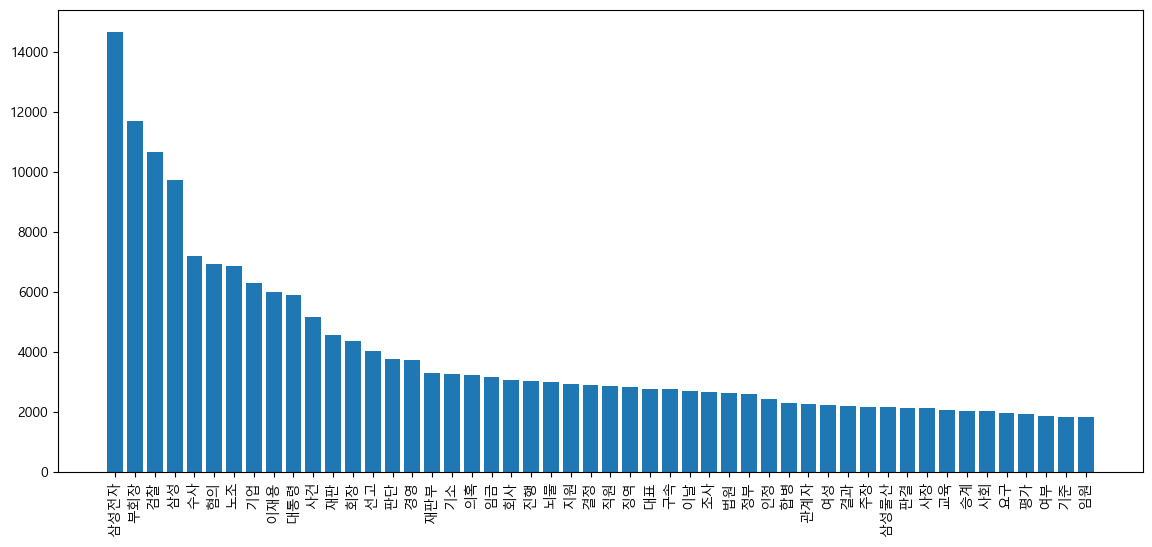

In [23]:
# '제목_세부내용_전처리후' 열에서 NaN 또는 float 값을 빈 문자열로 변환
df_bigkinds['제목_키워드_전처리후'] = df_bigkinds['제목_키워드_전처리후'].apply(lambda x: str(x) if isinstance(x, str) else '')

plt.figure(figsize=(14,6))

# 단어 빈도 계산
word_counts = Counter(' '.join(df_bigkinds['제목_키워드_전처리후']).split())

# 상위 20개 단어 시각화
common_words  = word_counts.most_common()[0:50]
words, counts = zip(*common_words)

plt.bar(words, counts)
plt.xticks(rotation=90)
plt.show()

4. 기본 전처리

In [26]:
# 앞뒤 공백 제거
df_bigkinds.loc[:, '제목_키워드_전처리후'] = df_bigkinds['제목_키워드_전처리후'].str.strip()

# 중간 공백 제거
df_bigkinds.loc[:, '제목_키워드_전처리후'] = df_bigkinds['제목_키워드_전처리후'].str.replace('\s+', ' ', regex=True)

In [28]:
df_bigkinds[['일자','제목_키워드_전처리후']][0:50]

,일자,제목_키워드_전처리후
0,2017-09-01,이재용 항소심 서울고법 형사 13부에 배당 이달중 첫 기일 이재용 항소심 13부 서...
1,2017-09-01,최순실게이트 청문회 불출석 11인 중 8명 백수 불출석 최순실게이트 청문회 백수 문...
2,2017-09-01,삼성 뇌물 이재용 항소심 신설 형사13부 배당 삼성 뇌물 신설 이재용 항소심 형사 ...
3,2017-09-01,두문불출 10개월만에 문고리 실세 이재만 안봉근 법정 나와 청문회불출석 인정 두문불...
4,2017-09-01,청문회 불출석 혐의 건강상태-절차적 하자로 무죄 주장 혐의 청문회 건강상태 절차적 ...
5,2017-09-01,이재용 항소심 서울고법 형사13부가 맡는다 이재용 항소심 서울고법 형사 한명숙 판결...
6,2017-09-04,라이선스 계약 수정 안하려다 퀄컴 또 좌절 수정 라이선스 계약 퀄컴 좌절 퀄컴 다국...
7,2017-09-04,법원 퀄컴 공정위 시정명령 효력정지신청 기각 법원 퀄컴 공정위 시정 명령 효력 정지...
8,2017-09-04,4대그룹 필기시험 면접 갈수록 커지는 인 적성검사 비중 문제 유형 미리 익혀라 적성...
9,2017-09-05,부음 강정홍씨 전 제민일보 편집국장 별세 강정홍씨 제민일보 편집국장 별세 강정홍 별...


5. 불용어 처리(형태소 분석 선언)

In [31]:
okt=Okt()
hannanum = Hannanum()
kkma=Kkma()
komoran = Komoran()

Okt

In [33]:
#기본 불용어 리스트 정의
stopwords = set([
'!',
'"',
#'$',
#'%',
'&',
"'",
'(',
')',
'*',
#'+',
',',
#'-',
'.',
'...',
# '0',
# '1',
# '2',
# '3',
# '4',
# '5',
# '6',
# '7',
# '8',
# '9',
';',
'<',
'=',
'>',
'?',
'@',
'\\', 
'^',
'_',
'`',
'|',
'~',
'·',
'?',
'??',
'‘',
'’',
'“',
'”',
'…',
'、',
'。',
'〈',
'〉',
'《',
'》',
'가',
'가까스로',
'가령',
'각',
'각각',
'각자',
'각종',
'갖고말하자면',
'같다',
'같이',
'개의치않고',
'거니와',
'거바',
'거의',
'것',
'것과 같이',
'것들',
'게다가',
'게우다',
'겨우',
'견지에서',
'결과에 이르다',
'결국',
'결론을 낼 수 있다',
'겸사겸사',
'고려하면',
'고로',
'곧',
'공동으로',
'과',
'과연',
'관계가 있다',
'관계없이',
'관련이 있다',
'관하여',
'관한',
'관해서는',
'구',
'구체적으로',
'구토하다',
'그',
'그들',
'그때',
'그래',
'그래도',
'그래서',
'그러나',
'그러니',
'그러니까',
'그러면',
'그러므로',
'그러한즉',
'그런 까닭에',
'그런데',
'그런즉',
'그럼',
'그럼에도 불구하고',
'그렇게 함으로써',
'그렇지',
'그렇지 않다면',
'그렇지 않으면',
'그렇지만',
'그렇지않으면',
'그리고',
'그리하여',
'그만이다',
'그에 따르는',
'그위에',
'그저',
'그중에서',
'그치지 않다',
'근거로',
'근거하여',
'기대여',
'기점으로',
'기준으로',
'기타',
'까닭으로',
'까악',
'까지',
'까지 미치다',
'까지도',
'꽈당',
'끙끙',
'끼익',
'나',
'나머지는',
'남들',
'남짓',
'너',
'너희',
'너희들',
'네',
'넷',
'년',
'논하지 않다',
'놀라다',
'누가 알겠는가',
'누구',
'다른',
'다른 방면으로',
'다만',
'다섯',
'다소',
'다수',
'다시 말하자면',
'다시말하면',
'다음',
'다음에',
'다음으로',
'단지',
'답다',
'당신',
'당장',
'대로 하다',
'대하면',
'대하여',
'대해 말하자면',
'대해서',
'댕그',
'더구나',
'더군다나',
'더라도',
'더불어',
'더욱더',
'더욱이는',
'도달하다',
'도착하다',
'동시에',
'동안',
'된바에야',
'된이상',
'두번째로',
'둘',
'둥둥',
'뒤따라',
'뒤이어',
'든간에',
'들',
'등',
'등등',
'딩동',
'따라',
'따라서',
'따위',
'따지지 않다',
'딱',
'때',
'때가 되어',
'때문에',
'또',
'또한',
'뚝뚝',
'라 해도',
'령',
'로',
'로 인하여',
'로부터',
'로써',
'륙',
'를',
'마음대로',
'마저',
'마저도',
'마치',
'막론하고',
'만 못하다',
'만약',
'만약에',
'만은 아니다',
'만이 아니다',
'만일',
'만큼',
'말하자면',
'말할것도 없고',
'매',
'매번',
'메쓰겁다',
'몇',
'모',
'모두',
'무렵',
'무릎쓰고',
'무슨',
'무엇',
'무엇때문에',
'물론',
'및',
'바꾸어말하면',
'바꾸어말하자면',
'바꾸어서 말하면',
'바꾸어서 한다면',
'바꿔 말하면',
'바로',
'바와같이',
'밖에 안된다',
'반대로',
'반대로 말하자면',
'반드시',
'버금',
'보는데서',
'보다더',
'보드득',
'본대로',
'봐',
'봐라',
'부류의 사람들',
'부터',
'불구하고',
'불문하고',
'붕붕',
'비걱거리다',
'비교적',
'비길수 없다',
'비로소',
'비록',
'비슷하다',
'비추어 보아',
'비하면',
'뿐만 아니라',
'뿐만아니라',
'뿐이다',
'삐걱',
'삐걱거리다',
'사',
'삼',
'상대적으로 말하자면',
'생각한대로',
'설령',
'설마',
'설사',
'셋',
'소생',
'소인',
'솨',
'쉿',
'습니까',
'습니다',
'시각',
'시간',
'시작하여',
'시초에',
'시키다',
'실로',
'심지어',
'아',
'아니',
'아니나다를가',
'아니라면',
'아니면',
'아니었다면',
'아래윗',
'아무거나',
'아무도',
'아야',
'아울러',
'아이',
'아이고',
'아이구',
'아이야',
'아이쿠',
'아하',
'아홉',
'안 그러면',
'않기 위하여',
'않기 위해서',
'알 수 있다',
'알았어',
'앗',
'앞에서',
'앞의것',
'야',
'약간',
'양자',
'어',
'어기여차',
'어느',
'어느 년도',
'어느것',
'어느곳',
'어느때',
'어느쪽',
'어느해',
'어디',
'어때',
'어떠한',
'어떤',
'어떤것',
'어떤것들',
'어떻게',
'어떻해',
'어이',
'어째서',
'어쨋든',
'어쩔수 없다',
'어찌',
'어찌됏든',
'어찌됏어',
'어찌하든지',
'어찌하여',
'언제',
'언젠가',
'얼마',
'얼마 안 되는 것',
'얼마간',
'얼마나',
'얼마든지',
'얼마만큼',
'얼마큼',
'엉엉',
'에',
'에 가서',
'에 달려 있다',
'에 대해',
'에 있다',
'에 한하다',
'에게',
'에서',
'여',
'여기',
'여덟',
'여러분',
'여보시오',
'여부',
'여섯',
'여전히',
'여차',
'연관되다',
'연이서',
'영',
'영차',
'옆사람',
'예',
'예를 들면',
'예를 들자면',
'예컨대',
'예하면',
'오',
'오로지',
'오르다',
'오자마자',
'오직',
'오호',
'오히려',
'와',
'와 같은 사람들',
'와르르',
'와아',
'왜',
'왜냐하면',
'외에도',
'요만큼',
'요만한 것',
'요만한걸',
'요컨대',
'우르르',
'우리',
'우리들',
'우선',
'우에 종합한것과같이',
'운운',
'월',
'위에서 서술한바와같이',
'위하여',
'위해서',
'윙윙',
'육',
'으로',
'으로 인하여',
'으로서',
'으로써',
'을',
'응',
'응당',
'의',
'의거하여',
'의지하여',
'의해',
'의해되다',
'의해서',
'이',
'이 되다',
'이 때문에',
'이 밖에',
'이 외에',
'이 정도의',
'이것',
'이곳',
'이때',
'이라면',
'이래',
'이러이러하다',
'이러한',
'이런',
'이럴정도로',
'이렇게 많은 것',
'이렇게되면',
'이렇게말하자면',
'이렇구나',
'이로 인하여',
'이르기까지',
'이리하여',
'이만큼',
'이번',
'이봐',
'이상',
'이어서',
'이었다',
'이와 같다',
'이와 같은',
'이와 반대로',
'이와같다면',
'이외에도',
'이용하여',
'이유만으로',
'이젠',
'이지만',
'이쪽',
'이천구',
'이천육',
'이천칠',
'이천팔',
'인 듯하다',
'인젠',
'일',
'일것이다',
'일곱',
'일단',
'일때',
'일반적으로',
'일지라도',
'임에 틀림없다',
'입각하여',
'입장에서',
'잇따라',
'있다',
'자',
'자기',
'자기집',
'자마자',
'자신',
'잠깐',
'잠시',
'저',
'저것',
'저것만큼',
'저기',
'저쪽',
'저희',
'전부',
'전자',
'전후',
'점에서 보아',
'정도에 이르다',
'제',
'제각기',
'제외하고',
'조금',
'조차',
'조차도',
'졸졸',
'좀',
'좋아',
'좍좍',
'주룩주룩',
'주저하지 않고',
'줄은 몰랏다',
'줄은모른다',
'중에서',
'중의하나',
'즈음하여',
'즉',
'즉시',
'지든지',
'지만',
'지말고',
'진짜로',
'쪽으로',
'차라리',
'참',
'참나',
'첫번째로',
'쳇',
'총적으로',
'총적으로 말하면',
'총적으로 보면',
'칠',
'콸콸',
'쾅쾅',
'쿵',
'타다',
'타인',
'탕탕',
'토하다',
'통하여',
'툭',
'퉤',
'틈타',
'팍',
'팔',
'퍽',
'펄렁',
'하',
'하게될것이다',
'하게하다',
'하겠는가',
'하고 있다',
'하고있었다',
'하곤하였다',
'하구나',
'하기 때문에',
'하기 위하여',
'하기는한데',
'하기만 하면',
'하기보다는',
'하기에',
'하나',
'하느니',
'하는 김에',
'하는 편이 낫다',
'하는것도',
'하는것만 못하다',
'하는것이 낫다',
'하는바',
'하더라도',
'하도다',
'하도록시키다',
'하도록하다',
'하든지',
'하려고하다',
'하마터면',
'하면 할수록',
'하면된다',
'하면서',
'하물며',
'하여금',
'하여야',
'하자마자',
'하지 않는다면',
'하지 않도록',
'하지마',
'하지마라',
'하지만',
'하하',
'한 까닭에',
'한 이유는',
'한 후',
'한다면',
'한다면 몰라도',
'한데',
'한마디',
'한적이있다',
'한켠으로는',
'한항목',
'할 따름이다',
'할 생각이다',
'할 줄 안다',
'할 지경이다',
'할 힘이 있다',
'할때',
'할만하다',
'할망정',
'할뿐',
'할수있다',
'할수있어',
'할줄알다',
'할지라도',
'할지언정',
'함께',
'해도된다',
'해도좋다',
'해봐요',
'해서는 안된다',
'해야한다',
'해요',
'했어요',
'향하다',
'향하여',
'향해서',
'허',
'허걱',
'허허',
'헉',
'헉헉',
'헐떡헐떡',
'형식으로 쓰여',
'혹시',
'혹은',
'혼자',
'훨씬',
'휘익',
'휴',
'흐흐',
'흥',
'힘입어',
'?',
'！',
'＃',
#'＄',
#'％',
'＆',
'（',
'）',
'＊',
'＋',
'，',
# 2ne1 같은 것도 걸러내기 때문에 제외
# '０',
# '１',
# '２',
# '３',
# '４',
# '５',
# '６',
# '７',
# '８',
# '９',
'：',
'；',
'＜',
'＞',
'？',
'＠',
'［',
'］',
'｛',
'｜',
'｝',
'～',
'￥',
'' , # 2014년도 데이터 문제로 추가
'목표주가', # 20240906 멘토링 후 일상 단어 제거 
'투자의견'
])

In [34]:
# 불용어 제거 함수 정의
def remove_stopwords(text):
    # text가 NaN 또는 float인 경우 빈 문자열로 처리
    if isinstance(text, float) or pd.isna(text):
        return ""

    tokens = okt.morphs(text)  # 형태소 단위로 분리
    filtered_tokens = [word for word in tokens if word not in stopwords]
    return ' '.join(filtered_tokens)

# '세부내용' 열에 불용어 제거 함수 적용
df_bigkinds['제목_키워드_전처리후_Okt'] = df_bigkinds['제목_키워드_전처리후'].apply(remove_stopwords)

In [35]:
df_bigkinds[['일자','제목_키워드_전처리후','제목_키워드_전처리후_Okt']]

,일자,제목_키워드_전처리후,제목_키워드_전처리후_Okt
0,2017-09-01,이재용 항소심 서울고법 형사 13부에 배당 이달중 첫 기일 이재용 항소심 13부 서...,이재용 항소심 서울 고법 형사 13 부 배당 달 중 첫 기일 이재용 항소심 13 부...
1,2017-09-01,최순실게이트 청문회 불출석 11인 중 8명 백수 불출석 최순실게이트 청문회 백수 문...,최 순 실 게이트 청문회 불 출석 11 인 중 8 명 백수 불 출석 최 순 실 게이...
2,2017-09-01,삼성 뇌물 이재용 항소심 신설 형사13부 배당 삼성 뇌물 신설 이재용 항소심 형사 ...,삼성 뇌물 이재용 항소심 신설 형사 13 부 배당 삼성 뇌물 신설 이재용 항소심 형...
3,2017-09-01,두문불출 10개월만에 문고리 실세 이재만 안봉근 법정 나와 청문회불출석 인정 두문불...,두문불출 10 개월 만에 문 고리 실세 이재만 안봉 근 법정 나와 청문회 불 출석 ...
4,2017-09-01,청문회 불출석 혐의 건강상태-절차적 하자로 무죄 주장 혐의 청문회 건강상태 절차적 ...,청문회 불 출석 혐의 건강 상태 - 절차 적 하자 무죄 주장 혐의 청문회 건강 상태...
...,...,...,...
6055,2024-08-26,수술 이송 재활 다 하는 로봇 의료대란 걱정 덜었다 수술 이송 재활 로봇 의료대 걱...,수술 이송 재활 다 하는 로봇 의료 대란 걱정 덜었다 수술 이송 재활 로봇 의료 대...
6056,2024-08-26,삼성전자 기흥 피폭 작업자 손에 기준치의 188배 피폭 삼성전자 기흥 피폭 작업자 ...,삼성 기흥 피폭 작업 손 기준 치의 188 배 피폭 삼성 기흥 피폭 작업 기 준치 ...
6057,2024-08-27,부음 이금선씨 별세 외 이금선 별세 이금선 별세 유경상 부산남구장애인복지관장 유철상...,부음 금선 씨 별세 외 금선 별세 금선 별세 유경 상 부산 남구 장애인 복지관 장 ...
6058,2024-08-27,부고 유영상 SK텔레콤 대표 모친상 유영상 SK 텔레콤 대표 모친상 이금선 별세 유...,부고 유영상 SK 텔레콤 대표 모친상 유영상 SK 텔레콤 대표 모친상 금선 별세 유...


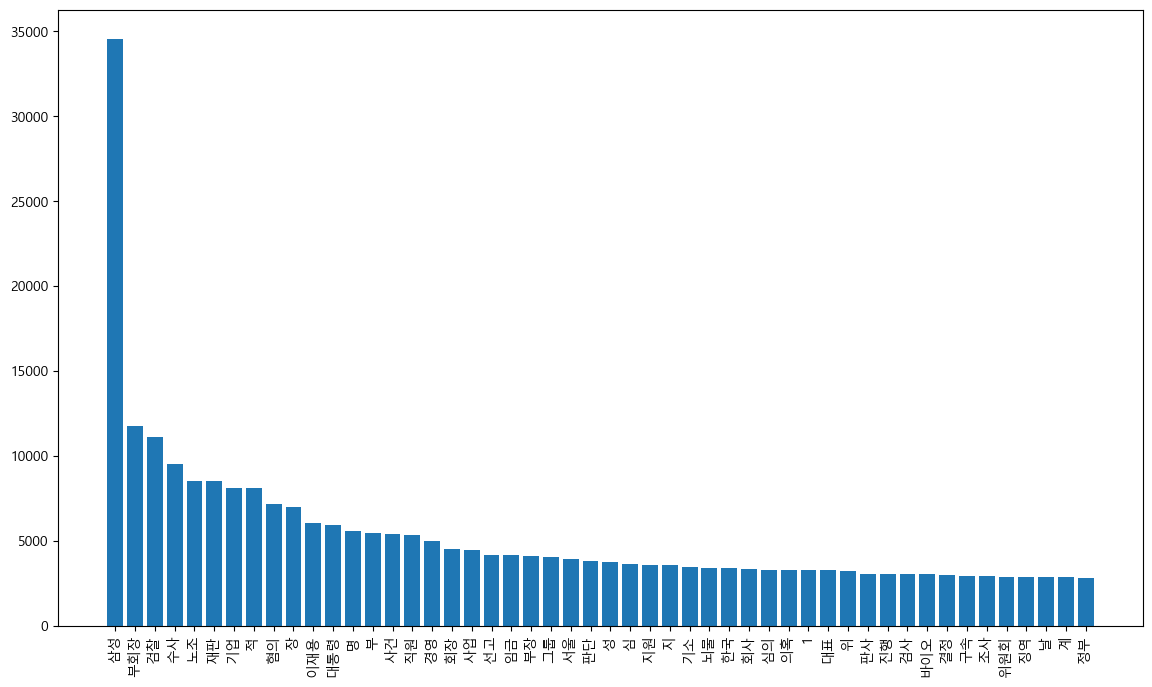

In [36]:
plt.figure(figsize=(14,8))

df_bigkinds['제목_키워드_전처리후_Okt'] = df_bigkinds['제목_키워드_전처리후_Okt'].astype(str)

# 단어 빈도 계산
word_counts = Counter(' '.join(df_bigkinds['제목_키워드_전처리후_Okt']).split())

# 상위 20개 단어 시각화
common_words  = word_counts.most_common()[0:50]
words, counts = zip(*common_words)

plt.bar(words, counts)
plt.xticks(rotation=90)
plt.show()

Hannanum

In [38]:
# 불용어 제거 함수 정의
def remove_stopwords(text):
    # text가 NaN 또는 float인 경우 빈 문자열로 처리
    if isinstance(text, float) or pd.isna(text):
        return ""

    tokens = hannanum.morphs(text)  # 형태소 단위로 분리
    filtered_tokens = [word for word in tokens if word not in stopwords]
    return ' '.join(filtered_tokens)

# '세부내용' 열에 불용어 제거 함수 적용
df_bigkinds['제목_키워드_전처리후_Hannanum'] = df_bigkinds['제목_키워드_전처리후'].apply(remove_stopwords)

In [39]:
df_bigkinds[['일자','제목_키워드_전처리후','제목_키워드_전처리후_Hannanum']][0:50]

,일자,제목_키워드_전처리후,제목_키워드_전처리후_Hannanum
0,2017-09-01,이재용 항소심 서울고법 형사 13부에 배당 이달중 첫 기일 이재용 항소심 13부 서...,이재용 항소심 서울고법 형사 13부 배당 이달 중 첫 기 ㄹ 이재용 항소심 13부 ...
1,2017-09-01,최순실게이트 청문회 불출석 11인 중 8명 백수 불출석 최순실게이트 청문회 백수 문...,최순실게이트 청문회 불출석 11 ㄴ 중 8명 백수 불출석 최순실게이트 청문회 백수 ...
2,2017-09-01,삼성 뇌물 이재용 항소심 신설 형사13부 배당 삼성 뇌물 신설 이재용 항소심 형사 ...,삼성 뇌물 이재용 항소심 신설 형사13부 배당 삼성 뇌물 신설 이재용 항소심 형사 ...
3,2017-09-01,두문불출 10개월만에 문고리 실세 이재만 안봉근 법정 나와 청문회불출석 인정 두문불...,두문불출 10개월 만에 문고리 실세 이재 만 안봉근 법정 청문회불출석 인정 두문불출...
4,2017-09-01,청문회 불출석 혐의 건강상태-절차적 하자로 무죄 주장 혐의 청문회 건강상태 절차적 ...,청문회 불출석 혐의 건강상태 - 절차적 하자 무죄 주장 혐의 청문회 건강상태 절차적...
5,2017-09-01,이재용 항소심 서울고법 형사13부가 맡는다 이재용 항소심 서울고법 형사 한명숙 판결...,이재용 항소심 서울고법 형사13부 맡 는다 이재용 항소심 서울고법 형사 한명숙 판결...
6,2017-09-04,라이선스 계약 수정 안하려다 퀄컴 또 좌절 수정 라이선스 계약 퀄컴 좌절 퀄컴 다국...,라이선스 계약 수정 안하 려다 퀄컴 좌절 수정 라이선스 계약 퀄컴 좌절 퀄컴 다국 ...
7,2017-09-04,법원 퀄컴 공정위 시정명령 효력정지신청 기각 법원 퀄컴 공정위 시정 명령 효력 정지...,법원 퀄컴 공정위 시정명령 효력정지신청 기각 법원 퀄컴 공정위 시정 명령 효력 정지...
8,2017-09-04,4대그룹 필기시험 면접 갈수록 커지는 인 적성검사 비중 문제 유형 미리 익혀라 적성...,4대그룹 필기시험 면접 ㄹ수록 크 지 는 ㄴ 적성검사 비중 문제 유형 미리 익히 어...
9,2017-09-05,부음 강정홍씨 전 제민일보 편집국장 별세 강정홍씨 제민일보 편집국장 별세 강정홍 별...,부음 강정홍씨 전 제민일보 편집국장 별세 강정홍씨 제민일보 편집국장 별세 강정홍 별...


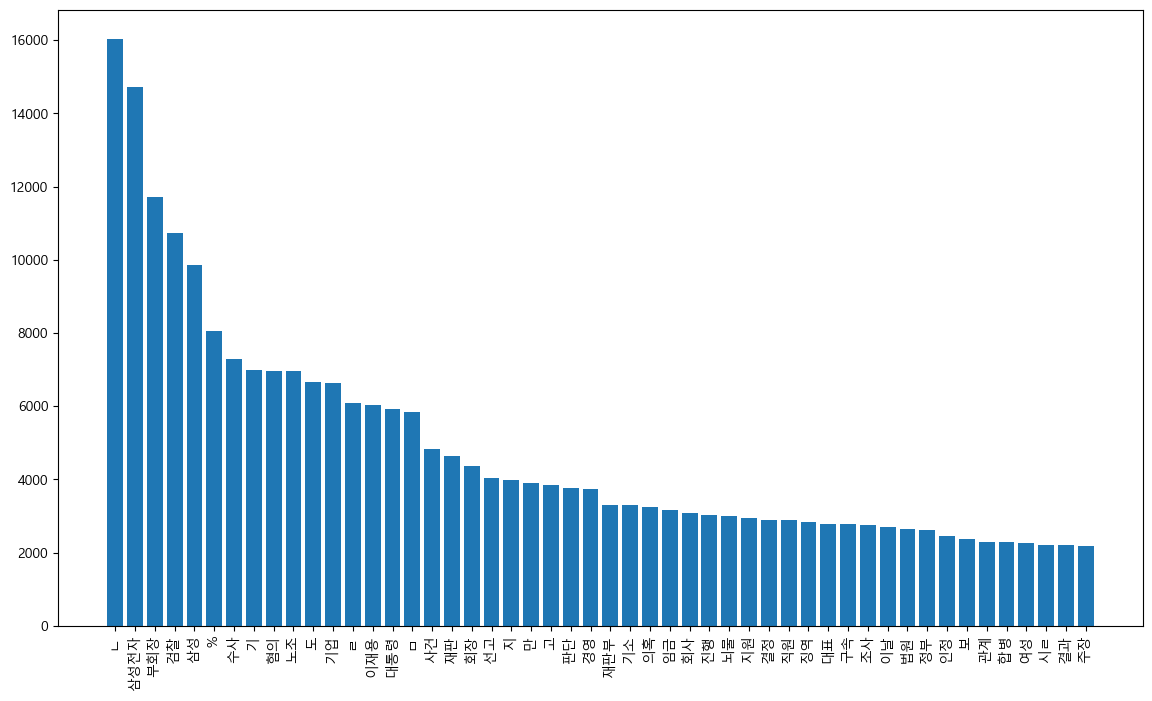

In [41]:
plt.figure(figsize=(14,8))

df_bigkinds['제목_키워드_전처리후_Hannanum'] = df_bigkinds['제목_키워드_전처리후_Hannanum'].astype(str)

# 단어 빈도 계산
word_counts = Counter(' '.join(df_bigkinds['제목_키워드_전처리후_Hannanum']).split())

# 상위 20개 단어 시각화
common_words  = word_counts.most_common()[0:50]
words, counts = zip(*common_words)

plt.bar(words, counts)
plt.xticks(rotation=90)
plt.show()

Kkma

In [44]:
# 불용어 제거 함수 정의
def remove_stopwords(text):
    # text가 NaN 또는 float인 경우 빈 문자열로 처리
    if isinstance(text, float) or pd.isna(text):
        return ""

    tokens = kkma.morphs(text)  # 형태소 단위로 분리
    filtered_tokens = [word for word in tokens if word not in stopwords]
    return ' '.join(filtered_tokens)

# '세부내용' 열에 불용어 제거 함수 적용
df_bigkinds['제목_키워드_전처리후_Kkma'] = df_bigkinds['제목_키워드_전처리후'].apply(remove_stopwords)

In [45]:
df_bigkinds[['일자','제목_키워드_전처리후','제목_키워드_전처리후_Kkma']][0:50]

,일자,제목_키워드_전처리후,제목_키워드_전처리후_Kkma
0,2017-09-01,이재용 항소심 서울고법 형사 13부에 배당 이달중 첫 기일 이재용 항소심 13부 서...,이재 용 항소심 서울 고법 형사 13 부 배당 이달 중 첫 기일 이재 용 항소심 1...
1,2017-09-01,최순실게이트 청문회 불출석 11인 중 8명 백수 불출석 최순실게이트 청문회 백수 문...,최 순 실 게이트 청문회 불 출석 11 인 중 8 명 백 수 불 출석 최 순 실 게...
2,2017-09-01,삼성 뇌물 이재용 항소심 신설 형사13부 배당 삼성 뇌물 신설 이재용 항소심 형사 ...,삼성 뇌물 이재 용 항소심 신설 형사 13 부 배당 삼성 뇌물 신설 이재 용 항소심...
3,2017-09-01,두문불출 10개월만에 문고리 실세 이재만 안봉근 법정 나와 청문회불출석 인정 두문불...,두문불출 10 개월 만 문고리 실세 이재 만 알 ㄴ 봉 근 법정 나오 청문회 불 출...
4,2017-09-01,청문회 불출석 혐의 건강상태-절차적 하자로 무죄 주장 혐의 청문회 건강상태 절차적 ...,청문회 불 출석 혐의 건강 상태 - 절차 적 하자 무죄 주장 혐의 청문회 건강 상태...
5,2017-09-01,이재용 항소심 서울고법 형사13부가 맡는다 이재용 항소심 서울고법 형사 한명숙 판결...,이재 용 항소심 서울 고법 형사 13 부 맡 는 다 이재 용 항소심 서울 고법 형사...
6,2017-09-04,라이선스 계약 수정 안하려다 퀄컴 또 좌절 수정 라이선스 계약 퀄컴 좌절 퀄컴 다국...,라이선스 계약 수정 안 려 다 퀄 컴 좌절 수정 라이선스 계약 퀄 컴 좌절 퀄 컴 ...
7,2017-09-04,법원 퀄컴 공정위 시정명령 효력정지신청 기각 법원 퀄컴 공정위 시정 명령 효력 정지...,법원 퀄 컴 공정위 시정 명령 효력 정지 신청 기각 법원 퀄 컴 공정위 시정 명령 ...
8,2017-09-04,4대그룹 필기시험 면접 갈수록 커지는 인 적성검사 비중 문제 유형 미리 익혀라 적성...,4 대 그룹 필기 시험 면접 갈수록 커지 는 인 적성 검사 비중 문제 유형 미리 익...
9,2017-09-05,부음 강정홍씨 전 제민일보 편집국장 별세 강정홍씨 제민일보 편집국장 별세 강정홍 별...,부음 강정 홍 씨 전 제민 일보 편집국장 별세 강정 홍 씨 제민 일보 편집국장 별세...


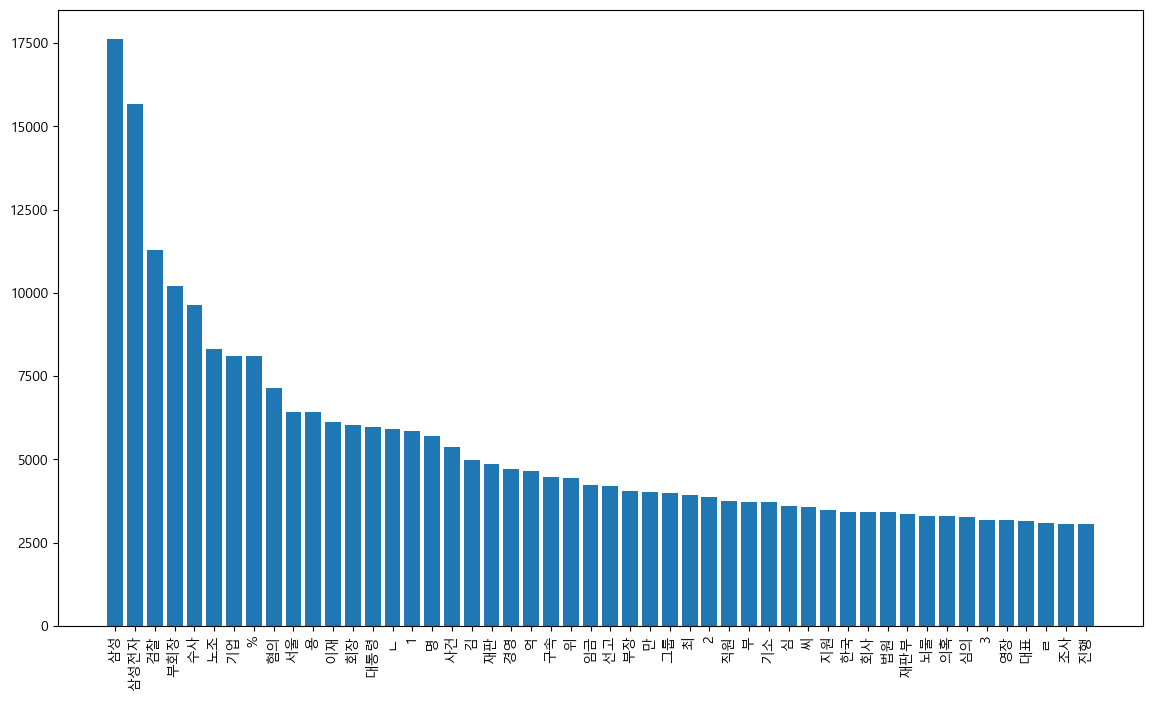

In [46]:
plt.figure(figsize=(14,8))

df_bigkinds['제목_키워드_전처리후_Kkma'] = df_bigkinds['제목_키워드_전처리후_Kkma'].astype(str)

# 단어 빈도 계산
word_counts = Counter(' '.join(df_bigkinds['제목_키워드_전처리후_Kkma']).split())

# 상위 20개 단어 시각화
common_words  = word_counts.most_common()[0:50]
words, counts = zip(*common_words)

plt.bar(words, counts)
plt.xticks(rotation=90)
plt.show()

Komoran

In [48]:
# 불용어 제거 함수 정의
def remove_stopwords(text):
    # text가 NaN 또는 float인 경우 빈 문자열로 처리
    if isinstance(text, float) or pd.isna(text):
        return ""

    tokens = komoran.morphs(text)  # 형태소 단위로 분리
    filtered_tokens = [word for word in tokens if word not in stopwords]
    return ' '.join(filtered_tokens)

# '세부내용' 열에 불용어 제거 함수 적용
df_bigkinds['제목_키워드_전처리후_Komoran'] = df_bigkinds['제목_키워드_전처리후'].apply(remove_stopwords)

In [49]:
df_bigkinds[['일자','제목_키워드_전처리후','제목_키워드_전처리후_Komoran']][0:50]

,일자,제목_키워드_전처리후,제목_키워드_전처리후_Komoran
0,2017-09-01,이재용 항소심 서울고법 형사 13부에 배당 이달중 첫 기일 이재용 항소심 13부 서...,이재용 항소심 서울고법 형사 13 부 배당 이달 중 첫 기일 이재용 항소심 13 부...
1,2017-09-01,최순실게이트 청문회 불출석 11인 중 8명 백수 불출석 최순실게이트 청문회 백수 문...,최순 실 게이트 청문회 불 출석 11 ㄴ 중 8 명 백수 불 출석 최순 실 게이트 ...
2,2017-09-01,삼성 뇌물 이재용 항소심 신설 형사13부 배당 삼성 뇌물 신설 이재용 항소심 형사 ...,삼성 뇌물 이재용 항소심 신설 형사 13 부 배당 삼성 뇌물 신설 이재용 항소심 형...
3,2017-09-01,두문불출 10개월만에 문고리 실세 이재만 안봉근 법정 나와 청문회불출석 인정 두문불...,두문불출 10 개월 만 문고리 실세 이재만 안 봉 근 법정 나오 청문회 불 출석 인...
4,2017-09-01,청문회 불출석 혐의 건강상태-절차적 하자로 무죄 주장 혐의 청문회 건강상태 절차적 ...,청문회 불 출석 혐의 건강 상태 - 절차 적 하자 무죄 주장 혐의 청문회 건강 상태...
5,2017-09-01,이재용 항소심 서울고법 형사13부가 맡는다 이재용 항소심 서울고법 형사 한명숙 판결...,이재용 항소심 서울고법 형사 13 부 맡 는다 이재용 항소심 서울고법 형사 한명숙 ...
6,2017-09-04,라이선스 계약 수정 안하려다 퀄컴 또 좌절 수정 라이선스 계약 퀄컴 좌절 퀄컴 다국...,라이선스 계약 수정 안 려다 퀄컴 좌절 수정 라이선스 계약 퀄컴 좌절 퀄컴 다국 통...
7,2017-09-04,법원 퀄컴 공정위 시정명령 효력정지신청 기각 법원 퀄컴 공정위 시정 명령 효력 정지...,법원 퀄컴 공정위 시정 명령 효력 정지 신청 기각 법원 퀄컴 공정위 시정 명령 효력...
8,2017-09-04,4대그룹 필기시험 면접 갈수록 커지는 인 적성검사 비중 문제 유형 미리 익혀라 적성...,4 대 그룹 필기시험 면접 갈수록 커지 는 인 적 성검사 비중 문제 유형 미리 익히...
9,2017-09-05,부음 강정홍씨 전 제민일보 편집국장 별세 강정홍씨 제민일보 편집국장 별세 강정홍 별...,부음 강 정홍 씨 전 제민일보 편집국장 별세 강 정홍 씨 제민일보 편집국장 별세 강...


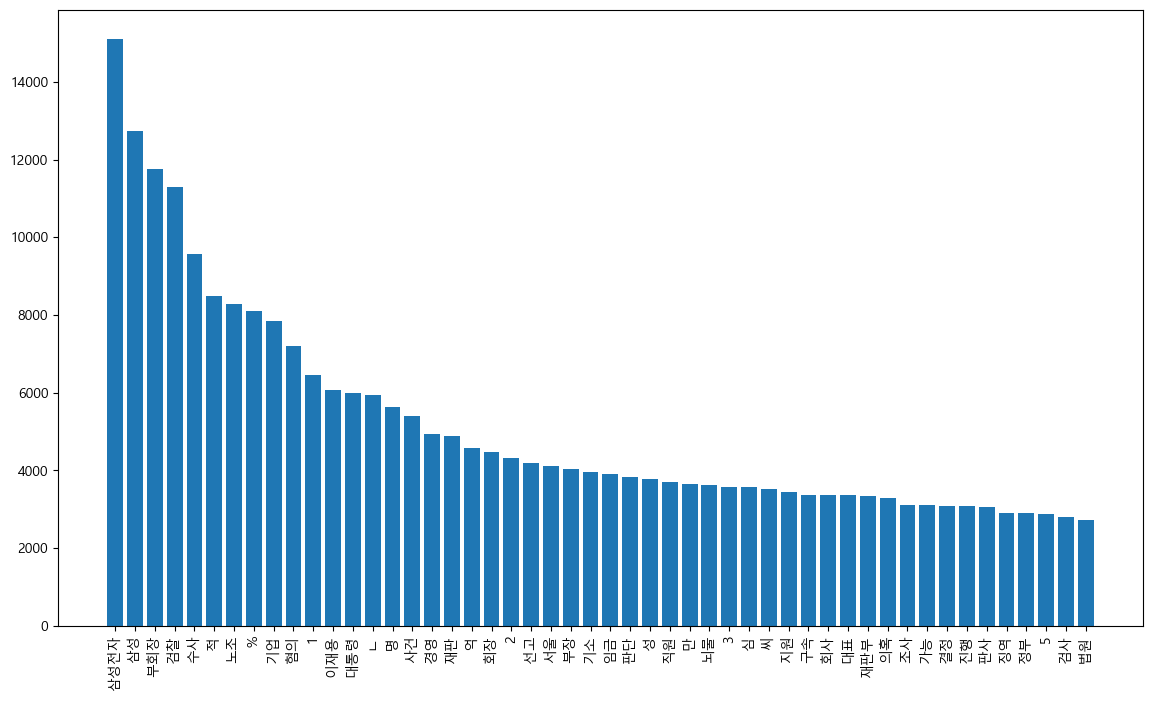

In [50]:
plt.figure(figsize=(14,8))

df_bigkinds['제목_키워드_전처리후_Komoran'] = df_bigkinds['제목_키워드_전처리후_Komoran'].astype(str)

# 단어 빈도 계산
word_counts = Counter(' '.join(df_bigkinds['제목_키워드_전처리후_Komoran']).split())

# 상위 20개 단어 시각화
common_words  = word_counts.most_common()[0:50]  # 21번째에서 40번째 단어
words, counts = zip(*common_words)

plt.bar(words, counts)
plt.xticks(rotation=90)
plt.show()

형태소 분석 성능이 만족스럽지 않아 키위 설치

In [52]:
from kiwipiepy import Kiwi

# Kiwi 객체 생성
kiwi = Kiwi()
# 시간 측정 시작
start_time = time.time()

# 텍스트를 형태소 분석하여 결과를 반환하는 함수
def analyze_text(text):
    result = kiwi.analyze(text)
    return result

# 형태소 분석 결과에서 명사를 추출하는 함수
def extract_nouns(text):
    nouns = []
    result = analyze_text(text)
    for token, pos, _, _ in result[0][0]:
        # 명사,알파벳,숫자
        # NNB : 11.1배의 배포함
        if len(token) != 1 and (pos.startswith('N') or pos.startswith('SL') or pos.startswith('VA') or
                                pos.startswith('SN') or pos.startswith('SF') or pos.startswith('SS') or
                                pos.startswith('MM') or pos.startswith('SY') or pos.startswith('NNB')):
            nouns.append(token)
    return nouns

# 텍스트 예시
tokenized_texts = [extract_nouns(text) for text in df_bigkinds['제목_키워드_전처리후']]

# 시간 측정 종료
end_time = time.time()

# 토큰화 시간 출력
print(f"Tokenization time: {end_time - start_time} seconds")
#print(tokenized_texts)

Tokenization time: 83.90431189537048 seconds


In [53]:
# '세부내용' 열에 불용어 제거 함수 적용
def remove_stopwords(text):
    # text가 NaN 또는 float인 경우 빈 문자열로 처리
    if isinstance(text, float) or pd.isna(text):
        return ""

    tokens = extract_nouns(text)
    filtered_tokens = [word for word in tokens if word not in stopwords]
    return ' '.join(filtered_tokens)

df_bigkinds['제목_키워드_전처리후_kiwi'] = df_bigkinds['제목_키워드_전처리후'].apply(remove_stopwords)

In [54]:
df_bigkinds[['일자','제목_키워드_전처리후','제목_키워드_전처리후_kiwi']]

,일자,제목_키워드_전처리후,제목_키워드_전처리후_kiwi
0,2017-09-01,이재용 항소심 서울고법 형사 13부에 배당 이달중 첫 기일 이재용 항소심 13부 서...,이재용 항소심 서울고법 형사 13 배당 이달 기일 이재용 항소심 13 서울고법 형사...
1,2017-09-01,최순실게이트 청문회 불출석 11인 중 8명 백수 불출석 최순실게이트 청문회 백수 문...,최순실 게이트 청문회 출석 11 백수 출석 최순실 게이트 청문회 백수 문고리 안봉근...
2,2017-09-01,삼성 뇌물 이재용 항소심 신설 형사13부 배당 삼성 뇌물 신설 이재용 항소심 형사 ...,삼성 뇌물 이재용 항소심 신설 형사 13 배당 삼성 뇌물 신설 이재용 항소심 형사 ...
3,2017-09-01,두문불출 10개월만에 문고리 실세 이재만 안봉근 법정 나와 청문회불출석 인정 두문불...,두문불출 10 개월 문고리 실세 이재만 안봉근 법정 청문회 출석 인정 두문불출 개월...
4,2017-09-01,청문회 불출석 혐의 건강상태-절차적 하자로 무죄 주장 혐의 청문회 건강상태 절차적 ...,청문회 출석 혐의 건강 상태 절차 하자 주장 혐의 청문회 건강 상태 절차 하자 무죄...
...,...,...,...
6055,2024-08-26,수술 이송 재활 다 하는 로봇 의료대란 걱정 덜었다 수술 이송 재활 로봇 의료대 걱...,수술 이송 재활 로봇 의료 대란 걱정 수술 이송 재활 로봇 의료 걱정 고령 필연 의...
6056,2024-08-26,삼성전자 기흥 피폭 작업자 손에 기준치의 188배 피폭 삼성전자 기흥 피폭 작업자 ...,삼성전자 기흥 피폭 작업자 기준 188 피폭 삼성전자 기흥 피폭 작업자 기준 피폭 ...
6057,2024-08-27,부음 이금선씨 별세 외 이금선 별세 이금선 별세 유경상 부산남구장애인복지관장 유철상...,부음 이금서 별세 이금서 별세 이금서 별세 유경 부산 남구 장애인 복지 관장 철상 ...
6058,2024-08-27,부고 유영상 SK텔레콤 대표 모친상 유영상 SK 텔레콤 대표 모친상 이금선 별세 유...,부고 유영 SK텔레콤 대표 모친 영상 SK 텔레콤 대표 모친 이금서 별세 유경 부산...


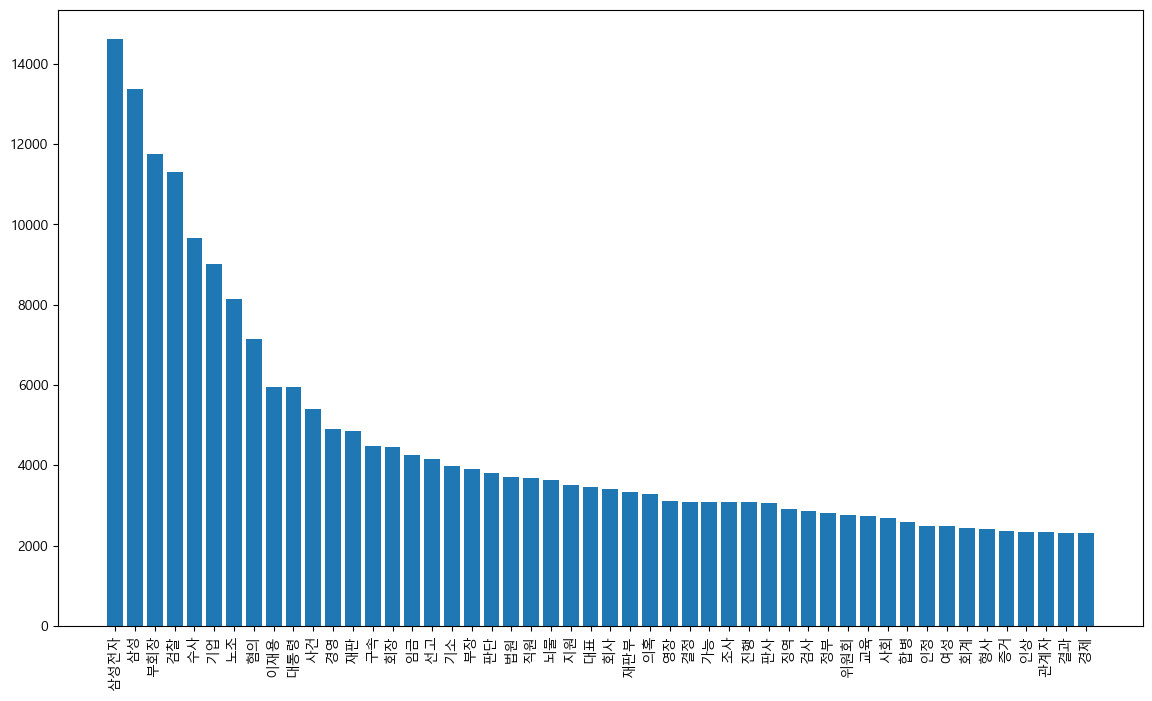

In [55]:
plt.figure(figsize=(14,8))

df_bigkinds['제목_키워드_전처리후_kiwi'] = df_bigkinds['제목_키워드_전처리후_kiwi'].astype(str)

# 단어 빈도 계산
word_counts = Counter(' '.join(df_bigkinds['제목_키워드_전처리후_kiwi']).split())

# 상위 20개 단어 시각화
common_words  = word_counts.most_common()[0:50]  # 21번째에서 40번째 단어
words, counts = zip(*common_words)

plt.bar(words, counts)
plt.xticks(rotation=90)
plt.show()

Komoran_명사

In [57]:
# '세부내용' 열에 불용어 제거 함수 적용
def remove_stopwords(text):
    # text가 NaN 또는 float인 경우 빈 문자열로 처리
    if isinstance(text, float) or pd.isna(text):
        return ""

    tokens = komoran.nouns(text)  # 형태소 단위로 분리
    filtered_tokens = [word for word in tokens if word not in stopwords]
    return ' '.join(filtered_tokens)

df_bigkinds['제목_키워드_전처리후_Komoran_명사'] = df_bigkinds['제목_키워드_전처리후'].apply(remove_stopwords)

In [58]:
df_bigkinds[['일자','제목_키워드_전처리후','제목_키워드_전처리후_Komoran_명사']][0:50]

,일자,제목_키워드_전처리후,제목_키워드_전처리후_Komoran_명사
0,2017-09-01,이재용 항소심 서울고법 형사 13부에 배당 이달중 첫 기일 이재용 항소심 13부 서...,이재용 항소심 서울고법 형사 부 배당 이달 중 기일 이재용 항소심 부 서울고법 형사...
1,2017-09-01,최순실게이트 청문회 불출석 11인 중 8명 백수 불출석 최순실게이트 청문회 백수 문...,최순 실 게이트 청문회 출석 중 명 백수 출석 최순 실 게이트 청문회 백수 문고리 ...
2,2017-09-01,삼성 뇌물 이재용 항소심 신설 형사13부 배당 삼성 뇌물 신설 이재용 항소심 형사 ...,삼성 뇌물 이재용 항소심 신설 형사 부 배당 삼성 뇌물 신설 이재용 항소심 형사 배...
3,2017-09-01,두문불출 10개월만에 문고리 실세 이재만 안봉근 법정 나와 청문회불출석 인정 두문불...,두문불출 개월 문고리 실세 이재만 안 봉 근 법정 청문회 출석 인정 두문불출 개월 ...
4,2017-09-01,청문회 불출석 혐의 건강상태-절차적 하자로 무죄 주장 혐의 청문회 건강상태 절차적 ...,청문회 출석 혐의 건강 상태 절차 하자 무죄 주장 혐의 청문회 건강 상태 절차 무죄...
5,2017-09-01,이재용 항소심 서울고법 형사13부가 맡는다 이재용 항소심 서울고법 형사 한명숙 판결...,이재용 항소심 서울고법 형사 부 이재용 항소심 서울고법 형사 한명숙 판결 뇌물 공여...
6,2017-09-04,라이선스 계약 수정 안하려다 퀄컴 또 좌절 수정 라이선스 계약 퀄컴 좌절 퀄컴 다국...,라이선스 계약 수정 안 퀄컴 좌절 수정 라이선스 계약 퀄컴 좌절 퀄컴 다국 통신업체...
7,2017-09-04,법원 퀄컴 공정위 시정명령 효력정지신청 기각 법원 퀄컴 공정위 시정 명령 효력 정지...,법원 퀄컴 공정위 시정 명령 효력 정지 신청 기각 법원 퀄컴 공정위 시정 명령 효력...
8,2017-09-04,4대그룹 필기시험 면접 갈수록 커지는 인 적성검사 비중 문제 유형 미리 익혀라 적성...,대 그룹 필기시험 면접 인 적 성검사 비중 문제 유형 적 성검사 비중 유형 적 성검...
9,2017-09-05,부음 강정홍씨 전 제민일보 편집국장 별세 강정홍씨 제민일보 편집국장 별세 강정홍 별...,부음 강 정홍 씨 제민일보 편집국장 별세 강 정홍 씨 제민일보 편집국장 별세 강 정...


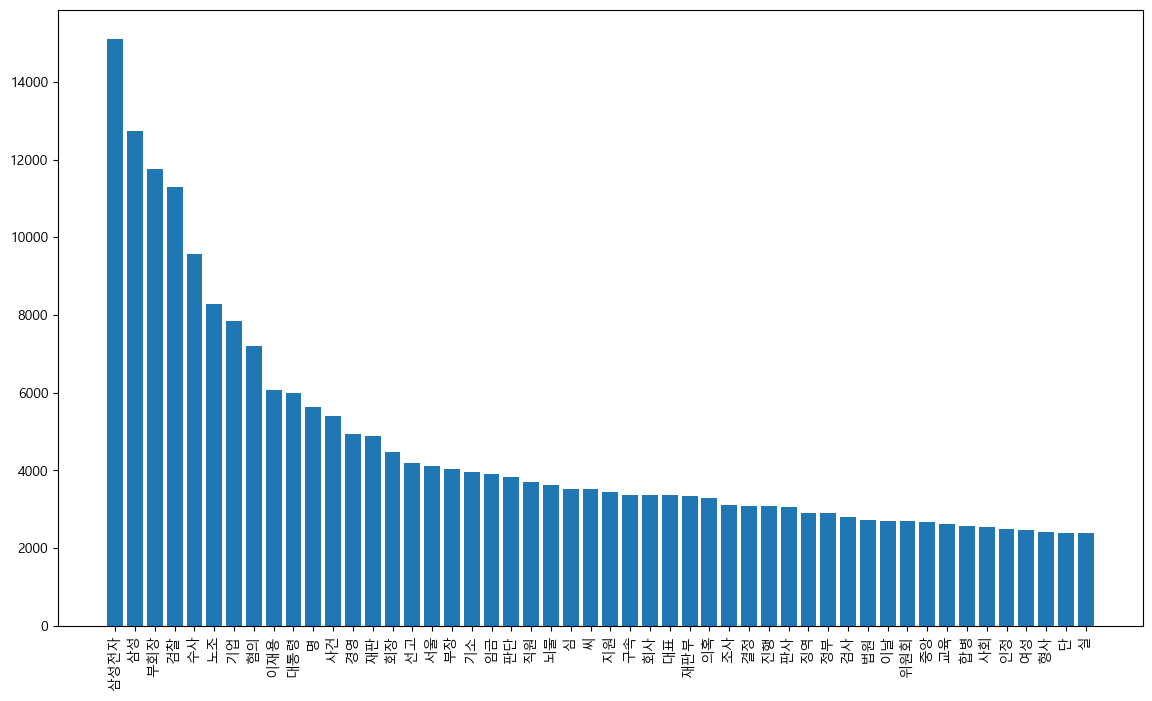

In [59]:
plt.figure(figsize=(14,8))

df_bigkinds['제목_키워드_전처리후_Komoran_명사'] = df_bigkinds['제목_키워드_전처리후_Komoran_명사'].astype(str)

# 단어 빈도 계산
word_counts = Counter(' '.join(df_bigkinds['제목_키워드_전처리후_Komoran_명사']).split())

# 상위 20개 단어 시각화
common_words  = word_counts.most_common()[0:50]  # 21번째에서 40번째 단어
words, counts = zip(*common_words)

plt.bar(words, counts)
plt.xticks(rotation=90)
plt.show()

In [60]:
# '제목_키워드_전처리후'가 공백인 행만 필터링
df_blank = df_bigkinds[df_bigkinds['제목_키워드_전처리후'].str.strip() == '']

# 필터링된 행들 출력
df_blank

,뉴스 식별자,일자,언론사,기고자,제목,통합 분류1,통합 분류2,통합 분류3,사건/사고 분류1,사건/사고 분류2,...,URL,분석제외 여부,제목_키워드,제목_키워드_전처리후,제목_키워드_전처리후_Okt,제목_키워드_전처리후_Hannanum,제목_키워드_전처리후_Kkma,제목_키워드_전처리후_Komoran,제목_키워드_전처리후_kiwi,제목_키워드_전처리후_Komoran_명사


In [61]:
df_bigkinds.columns

Index(['뉴스 식별자', '일자', '언론사', '기고자', '제목', '통합 분류1', '통합 분류2', '통합 분류3',
       '사건/사고 분류1', '사건/사고 분류2', '사건/사고 분류3', '인물', '위치', '기관', '키워드',
       '특성추출(가중치순 상위 50개)', '본문', 'URL', '분석제외 여부', '제목_키워드', '제목_키워드_전처리후',
       '제목_키워드_전처리후_Okt', '제목_키워드_전처리후_Hannanum', '제목_키워드_전처리후_Kkma',
       '제목_키워드_전처리후_Komoran', '제목_키워드_전처리후_kiwi', '제목_키워드_전처리후_Komoran_명사'],
      dtype='object')

In [62]:
df_bigkinds.to_excel('./Text_Data/bigkinds/삼성전자_사회_20170901-20240830_전처리후.xlsx', index=False)

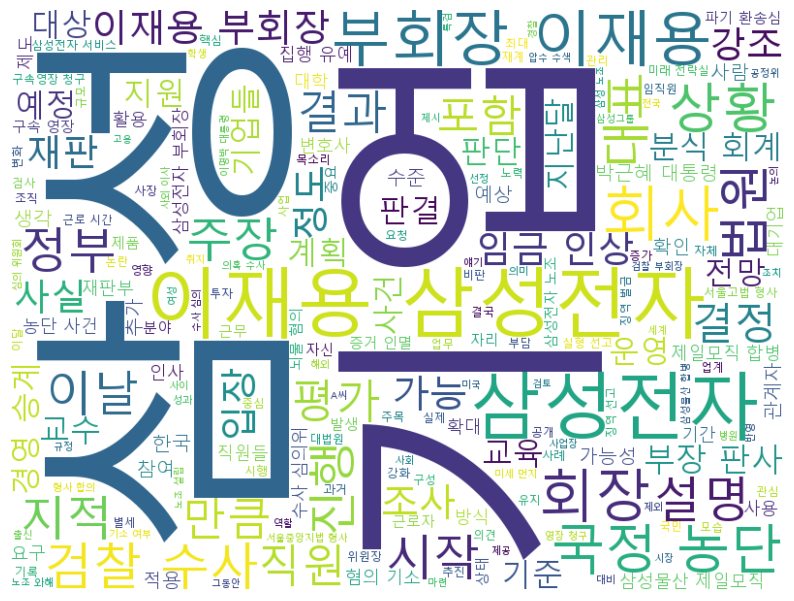

In [63]:
# 제목과 세부내용 전처리 후 텍스트를 모두 하나의 문자열로 결합
text_data = " ".join(df_bigkinds['제목_키워드_전처리후'].dropna())

# 워드클라우드 생성
wordcloud = WordCloud(
    font_path='C:/Windows/Fonts/malgun.ttf', # 한글 폰트 설정 (Windows에서 한글 폰트 경로를 지정)
    background_color='white',
    width=800,
    height=600
).generate(text_data)

# 워드클라우드 시각화
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # 축을 숨김
plt.show()

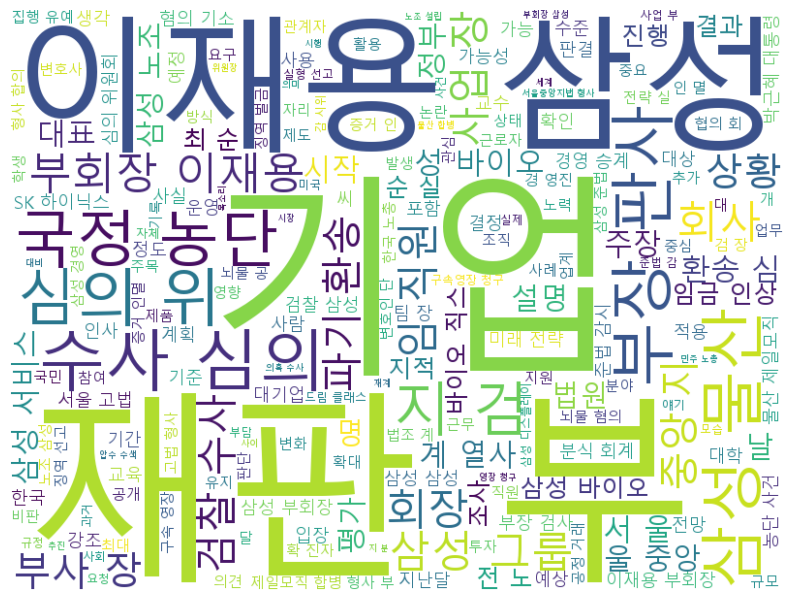

In [64]:
# 제목과 세부내용 전처리 후 텍스트를 모두 하나의 문자열로 결합
text_data = " ".join(df_bigkinds['제목_키워드_전처리후_Okt'].dropna())

# 워드클라우드 생성
wordcloud = WordCloud(
    font_path='C:/Windows/Fonts/malgun.ttf', # 한글 폰트 설정 (Windows에서 한글 폰트 경로를 지정)
    background_color='white',
    width=800,
    height=600
).generate(text_data)

# 워드클라우드 시각화
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # 축을 숨김
plt.show()

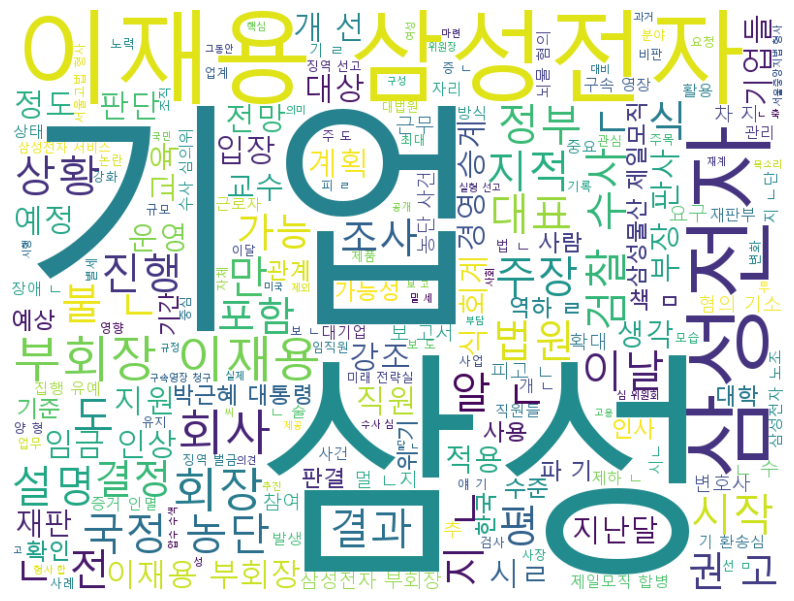

In [65]:
# 제목과 세부내용 전처리 후 텍스트를 모두 하나의 문자열로 결합
text_data = " ".join(df_bigkinds['제목_키워드_전처리후_Hannanum'].dropna())

# 워드클라우드 생성
wordcloud = WordCloud(
    font_path='C:/Windows/Fonts/malgun.ttf', # 한글 폰트 설정 (Windows에서 한글 폰트 경로를 지정)
    background_color='white',
    width=800,
    height=600
).generate(text_data)

# 워드클라우드 시각화
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # 축을 숨김
plt.show()

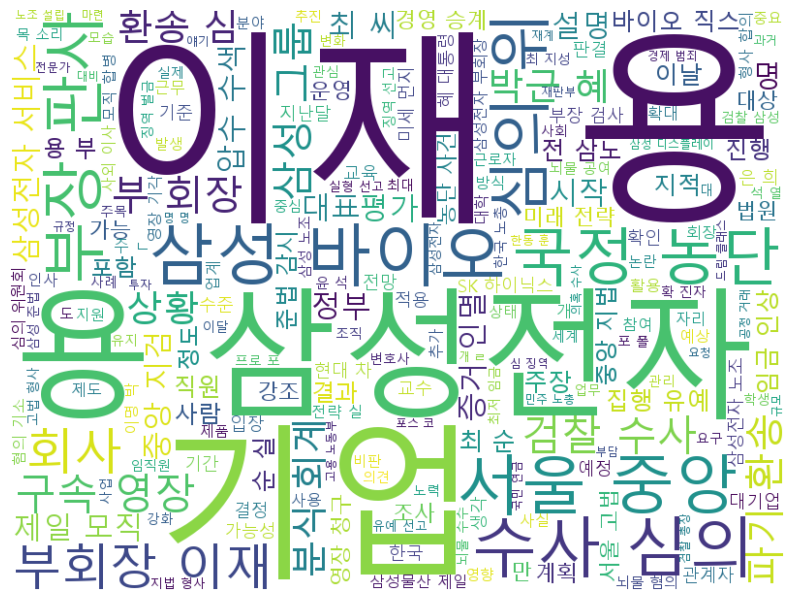

In [66]:
# 제목과 세부내용 전처리 후 텍스트를 모두 하나의 문자열로 결합
text_data = " ".join(df_bigkinds['제목_키워드_전처리후_Kkma'].dropna())

# 워드클라우드 생성
wordcloud = WordCloud(
    font_path='C:/Windows/Fonts/malgun.ttf', # 한글 폰트 설정 (Windows에서 한글 폰트 경로를 지정)
    background_color='white',
    width=800,
    height=600
).generate(text_data)

# 워드클라우드 시각화
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # 축을 숨김
plt.show()

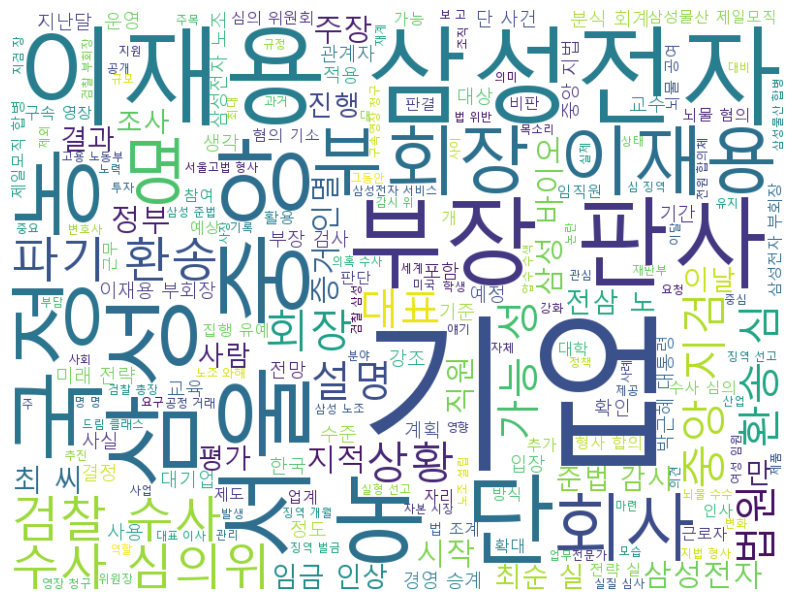

In [67]:
# 제목과 세부내용 전처리 후 텍스트를 모두 하나의 문자열로 결합
text_data = " ".join(df_bigkinds['제목_키워드_전처리후_Komoran'].dropna())

# 워드클라우드 생성
wordcloud = WordCloud(
    font_path='C:/Windows/Fonts/malgun.ttf', # 한글 폰트 설정 (Windows에서 한글 폰트 경로를 지정)
    background_color='white',
    width=800,
    height=600
).generate(text_data)

# 워드클라우드 시각화
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # 축을 숨김
plt.show()

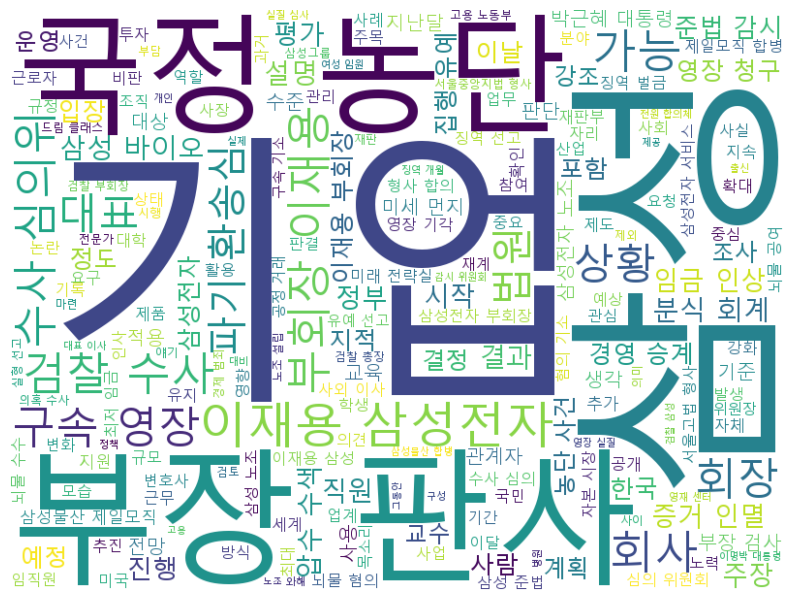

In [68]:
# 제목과 세부내용 전처리 후 텍스트를 모두 하나의 문자열로 결합
text_data = " ".join(df_bigkinds['제목_키워드_전처리후_kiwi'].dropna())

# 워드클라우드 생성
wordcloud = WordCloud(
    font_path='C:/Windows/Fonts/malgun.ttf', # 한글 폰트 설정 (Windows에서 한글 폰트 경로를 지정)
    background_color='white',
    width=800,
    height=600
).generate(text_data)

# 워드클라우드 시각화
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # 축을 숨김
plt.show()

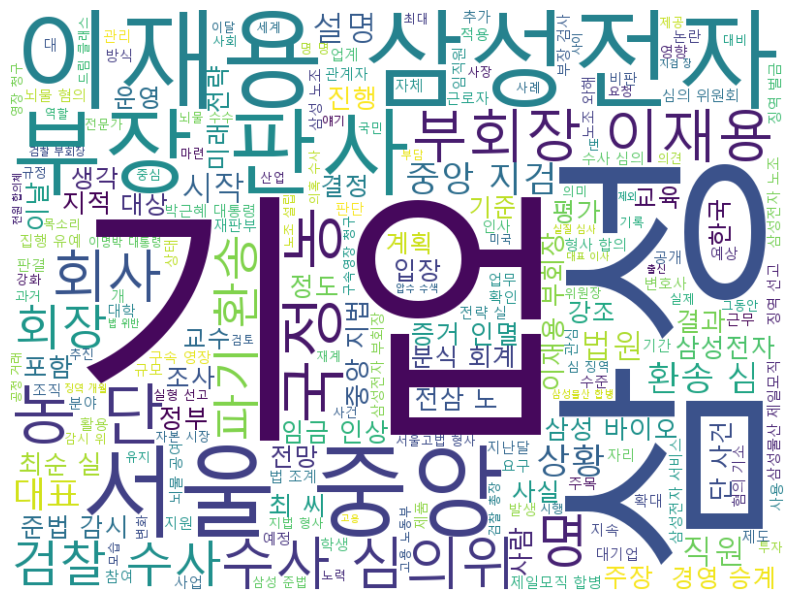

In [69]:
# 제목과 세부내용 전처리 후 텍스트를 모두 하나의 문자열로 결합
text_data = " ".join(df_bigkinds['제목_키워드_전처리후_Komoran_명사'].dropna())

# 워드클라우드 생성
wordcloud = WordCloud(
    font_path='C:/Windows/Fonts/malgun.ttf', # 한글 폰트 설정 (Windows에서 한글 폰트 경로를 지정)
    background_color='white',
    width=800,
    height=600
).generate(text_data)

# 워드클라우드 시각화
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # 축을 숨김
plt.show()

In [70]:
df_bigkinds['일자'] = pd.to_datetime(df_bigkinds['일자'])

In [71]:
df_count = df_bigkinds.groupby('일자').size().reset_index(name='건수')

# 결과 출력
print(df_count)

             일자  건수
0    2017-09-01   6
1    2017-09-04   3
2    2017-09-05   7
3    2017-09-06   2
4    2017-09-07   6
...         ...  ..
1719 2024-08-23   1
1720 2024-08-25   1
1721 2024-08-26   2
1722 2024-08-27   2
1723 2024-08-29   1

[1724 rows x 2 columns]


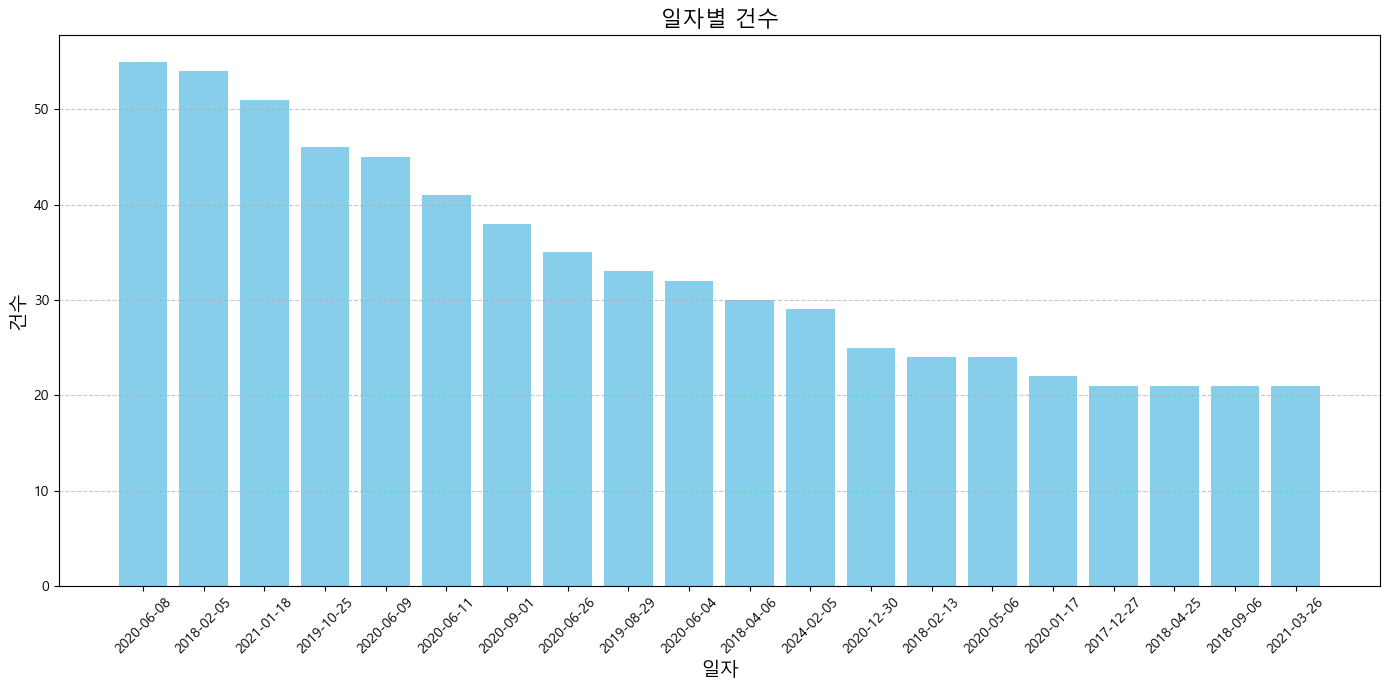

In [72]:
# 작성일별 건수 상위 20개 선택
df_count = df_count.nlargest(20, '건수')

# 그래프 그리기
plt.figure(figsize=(14, 7))
plt.bar(df_count['일자'].dt.strftime('%Y-%m-%d'), df_count['건수'], color='skyblue')

plt.xlabel('일자', fontsize=14)
plt.ylabel('건수', fontsize=14)
plt.title('일자별 건수', fontsize=16)

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()